# 🕒Time Series Course: A Practical Guide😎

출처 : https://www.kaggle.com/code/ivanlydkin/time-series-course-a-practical-guide

# SETTINGS

 ## imports

In [4]:
# 장문의 log 비출력 용도

%%capture
!pip install pandas==1.4.2

UsageError: Line magic function `%%capture` not found.


In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
import joblib # 대규모 데이터 numpy 직/역직렬화 library

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

from warnings import simplefilter
simplefilter("ignore")

## load data
- **train.csv**: 훈련 데이터로, store_nbr, family, onpromotion의 특징과 목표 판매량의 시계열을 포함합니다.
- *store_nbr*: 제품이 판매되는 매장을 식별합니다.
- *family*: 판매된 제품의 종류를 식별합니다.
- *sales*: 특정 매장의 특정 날짜에 제품군의 총 판매량을 나타냅니다. 제품이 분수 단위로 판매될 수 있기 때문에 소수점 값도 가능합니다 (예: 치즈 1.5kg, 칩 한 봉지와는 다르게).
- *onpromotion*: 특정 날짜에 특정 매장에서 프로모션 중인 제품군의 총 품목 수를 나타냅니다.

- **test.csv**: 테스트 데이터로, 훈련 데이터와 동일한 특징을 가지고 있습니다. 이 파일의 날짜에 대한 목표 판매량을 예측합니다. 테스트 데이터의 날짜는 훈련 데이터의 마지막 날짜 이후 15일간입니다.

- **holidays_events.csv**: 대체 공휴일 유의

- **Additional Notes**: 공공 부문의 임금은 매달 15일과 마지막 날에 지급. 이는 슈퍼마켓 판매에 영향을 미칠 수 있습니다. 2016년 4월 16일, 에콰도르에서 규모 7.8의 지진이 발생했습니다. 사람들은 구호 활동에 참여하여 물과 기타 필수 제품을 기부했으며, 이는 지진 후 몇 주 동안 슈퍼마켓 판매에 큰 영향을 미쳤습니다.


In [6]:
# 데이터 파일이 저장된 디렉토리를 지정합니다.
comp_dir = Path('/kaggle/input/store-sales-time-series-forecasting')

# train.csv 파일을 읽어옵니다. 필요한 컬럼만 선택하고, 데이터 타입을 지정합니다.
train = pd.read_csv(comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],  # 사용할 컬럼을 지정합니다.(date, id 제외)
    dtype={
        'store_nbr': 'category',  # store_nbr을 범주형 데이터로 설정합니다.
        'family': 'category',  # family를 범주형 데이터로 설정합니다.
        'sales': 'float32',  # sales를 float32 타입으로 설정합니다.
        'onpromotion': 'uint32'  # onpromotion을 uint32(부호 없는 정수) 타입으로 설정합니다.
    },
    parse_dates=['date'],  # date 컬럼을 날짜 형식으로 파싱합니다.
    infer_datetime_format=True,  # 날짜 형식을 자동으로 추론합니다.
)

# date 컬럼을 일(Day) 단위의 기간(period)로 변환합니다.
train['date'] = train.date.dt.to_period('D')

# 데이터 프레임의 인덱스를 설정하고 정렬합니다.
train = (train
       .set_index(['date', 'family', 'store_nbr'])  # date, family, store_nbr 컬럼을 인덱스로 설정합니다.
       .sort_index()  # 인덱스를 기준으로 정렬합니다.
)


In [7]:
print(train.head)

<bound method NDFrame.head of                                      sales  onpromotion
date       family     store_nbr                        
2013-01-01 AUTOMOTIVE 1           0.000000            0
                      10          0.000000            0
                      11          0.000000            0
                      12          0.000000            0
                      13          0.000000            0
...                                    ...          ...
2017-08-15 SEAFOOD    54          3.000000            0
                      6          47.575001            0
                      7          46.507000            0
                      8          23.330000            0
                      9          16.000000            0

[3000888 rows x 2 columns]>


In [8]:
test = pd.read_csv(comp_dir/'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['date', 'family', 'store_nbr']).sort_index()

In [9]:
holidays_events = pd.read_csv(
    comp_dir/ "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

## Visualization Settings

In [10]:
# matplotlib 및 seaborn의 기본 설정을 구성합니다.
import matplotlib.pyplot as plt
import seaborn as sns

# seaborn-whitegrid 스타일을 사용합니다.
plt.style.use("seaborn-whitegrid")

# figure의 기본 설정을 지정합니다.
plt.rc(
    "figure",
    autolayout=True,    # 자동 레이아웃 설정
    figsize=(11, 4),    # 기본 크기를 (11, 4)로 설정
    titlesize=18,       # 제목 크기를 18로 설정
    titleweight='bold', # 제목의 두께를 굵게 설정
)

# axes(축)의 기본 설정을 지정합니다.
plt.rc(
    "axes",
    labelweight="bold",  # 레이블의 두께를 굵게 설정
    labelsize="large",   # 레이블 크기를 크게 설정
    titleweight="bold",  # 축 제목의 두께를 굵게 설정
    titlesize=16,        # 축 제목 크기를 16으로 설정
    titlepad=10,         # 축 제목과 축 사이의 간격을 10으로 설정
)

# 플롯 매개변수 기본 설정을 지정합니다.
plot_params = dict(
    color="#556B2F",           # 선 색상을 설정합니다.
    style=".-",                # 선 스타일을 점과 선으로 설정합니다.
    markeredgecolor="#4169E1", # 마커 테두리 색상을 설정합니다.
    markerfacecolor="#8B0000", # 마커 내부 색상을 설정합니다.
    legend=False               # 범례를 표시하지 않도록 설정합니다.
)

# 인라인 백엔드에서 고해상도 그림을 표시하도록 설정합니다.
%config InlineBackend.figure_format = 'retina'


### Data display parameters

<blockquote style="margin-right:auto; margin-left:auto; background-color: #faf0be; padding: 1em; margin:0px;">
<strong> Here is where you can pick what the rest of the notebook will be showing you </strong></blockquote>

In [11]:
STORE  = '1'
FAMILY = 'BREAD/BAKERY'
START = '2016-01-01'
END = '2016-06-15'

print (
    f'Number of stores:\033[1m{train.index.get_level_values("store_nbr").nunique()}\033[0m \n\n'
    f'Time range in the training set: from \033[1m{train.index.get_level_values("date")[0]}\033[0m till \033[1m{train.index.get_level_values("date")[-1]}\033[0m \n\n'
    f'FAMILY options:{train.index.get_level_values("family").unique().astype("str")}'
)

Number of stores:54 

Time range in the training set: from 2013-01-01 till 2017-08-15 

FAMILY options:Index(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
       'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
      dtype='object', name='family')


In [13]:
# 특정 기간 동안의 특정 제품군과 매장의 판매량을 시각화하고, 예측 모델의 성능을 평가
# 시각화를 위한 주요 함수
def check(X, 
          y=train, 
          START=START, 
          END=END, 
          FAMILY=FAMILY, 
          STORE=None, 
          Prefix=None, 
          model=None, 
          FIT=True):
    
    if y is train:
        # y가 train인 경우, 모든 매장의 평균 값을 계산합니다.
        y =  (train
              .groupby(['family', 'date'])                  # 모든 매장에 대한
              .mean()                                       # 단순화를 위해 평균 값을 사용합니다.
              .query('family == @FAMILY')                   # 특정 제품군에 대한 데이터를 필터링합니다.
              .reset_index(level='family')
              .rename(columns={'sales':'ground_truth_average'})
              .loc[START:END, 'ground_truth_average']
              )
    else:
        # y가 다른 데이터인 경우, 스택하여 특정 제품군과 매장에 대한 데이터를 필터링합니다.
        y = (y
             .stack([0, 1])
             .to_frame()
             .query('family == @FAMILY and store_nbr == @STORE')
             .reset_index(['family', 'store_nbr'], drop=True)
             .rename(columns={0: 'ground_truth'})
             .loc[START:END]
             .squeeze()
            )
   
    if STORE:
        # 특정 매장에 대한 데이터를 필터링합니다.
        X = (X
             .query('family == @FAMILY and store_nbr == @STORE')
             .reset_index(['family', 'store_nbr'], drop=True)
           )
       
    X_check = X.loc[START:END, :]
    
    if model:
        model_ = model    
    else:
        model_ = LinearRegression(fit_intercept=False)
        
    if FIT:
        # 모델을 학습하고 예측 값을 계산합니다.
        model_.fit(X_check, y)
        y_fit = pd.Series(model_.predict(X_check), index=X_check.index, name='y_fit').clip(0.0)
    else:
        y_fit = X_check.squeeze()
            
    rmsle_train = mean_squared_log_error(y, y_fit) ** 0.5

    print(f'Mean Squared Log Error: \033[1m{rmsle_train:.5f}\033[0m')
    
    ax = y.plot(**plot_params, alpha=0.5)  # 실제 값을 플로팅합니다.
    y_fit.plot(ax=ax, color="#4B0082")     # 예측 값을 플로팅합니다.
    
    if Prefix:
        ax.set_title(f'{Prefix} for {FAMILY} at store {STORE} from {START} till {END}')
    else:
        ax.set_title(f'Average sales of {FAMILY} from {START} till {END}')
    ax.legend()


## Data sets for training and visualization

In [14]:
# train 데이터를 복사하여 X_train에 저장합니다.
X_train = train.copy()

# y_train을 생성합니다. 'family'와 'store_nbr' 인덱스를 풀고 'sales' 열을 선택합니다.
y_train = (X_train
           .unstack(['family', 'store_nbr'])  # 'family'와 'store_nbr' 인덱스를 풀어줍니다.
           .loc[:, "sales"]  # 'sales' 열만 선택합니다.
          )
# y_train = X_train.unstack(['family', 'store_nbr'])['sales']

# 단순 날짜 인덱스를 생성합니다.
index_ = X_train.index.get_level_values('date').unique()

# 필터링된 데이터에 대한 true 값을 생성합니다.
y_true = (y_train
         .stack(['family', 'store_nbr'])  # 'family'와 'store_nbr' 레벨을 다시 쌓아줍니다.
         .to_frame()  # 데이터프레임으로 변환합니다.
         .query('family == @FAMILY and store_nbr == @STORE')  # 지정된 제품군과 매장에 대해 필터링합니다.
         .reset_index(['family', 'store_nbr'], drop=True)  # 'family'와 'store_nbr' 인덱스를 제거합니다.
         .rename(columns={0: 'ground_truth'})  # 컬럼 이름을 'ground_truth'로 변경합니다.
         .loc[START:END, :]  # 시작일과 종료일로 필터링합니다.
         .squeeze()  # 시리즈 형태로 변환합니다.
        )


In [15]:
y_true

date
2016-01-01      0.000000
2016-01-02    259.811005
2016-01-03    138.274994
2016-01-04    552.171997
2016-01-05    461.738007
                 ...    
2016-06-11    417.851990
2016-06-12    183.319000
2016-06-13    462.028992
2016-06-14    467.203003
2016-06-15    507.850006
Freq: D, Name: ground_truth, Length: 167, dtype: float32

# *A theoretical issue*: **MultiIndex**
이것은 이론의 실제 응용의 시작점이라고 생각합니다.

시계열에서 우리는 시간적 의존성을 분석합니다. 이는 목표 변수의 상태를 다른 시간대에서 비교하는 것을 의미합니다. 이로 인해 몇 가지 사항이 따릅니다:

- 각 목표 단위는 해당 시점에서 모든 객체의 상태에 대한 정보를 포함하는 시간 인덱스 시리즈여야 합니다. 따라서 각 열에는 동일한 객체의 시간 변화 값이 포함됩니다. 즉, 냉동 피자와 자전거는 별도의 열에 있으며, 각 열은 연구된 매개변수(가격, 판매된 단위 등)의 시간 변화를 포함합니다.

- 피자는 피자대로, 자전거는 자전거대로 유지하려면 데이터를 모든 범주형 특징으로 그룹화하고 'wide' 시리즈로 펼쳐야 합니다. 그런 다음 이 시리즈를 각 새로운 순간에 가져와 DataFrame을 한 줄씩 구성합니다. 이것이 우리의 `y`입니다.

여기서 MultiIndex가 유용합니다.

1. 모든 범주형 특징을 인덱스에 추가하고 이를 MultiIndex로 만듭니다:  
`.set_index(['date', 'family', 'store_nbr']`. <br>
*이제 인덱스에 3개의 열이 있고, 각 행마다 1개의 TARGET 값이 있습니다.*

2. 'date'를 제외한 모든 인덱스 레벨을 열(긴 형식)에서 행(넓은 형식)으로 피벗합니다. 여전히 동일한 MultiIndex입니다!
`unstack(['family', 'store_nbr'])` <br>
*이제 인덱스에 'date' 열 하나와 2개의 행이 있으며, TARGET은 **1782** 값이 각 행에 있습니다.* 

이것이 왜 유용할까요? 이제 우리는 다른 모든 시계열과 마찬가지로 표준 **'dates'** 열을 가지고 있기 때문입니다. <br>
`.loc['2017-01-01']`을 쿼리하면, 33개의 매장에서 54개의 상품군이 각각 고유하게 인덱스된 1782 값의 배열을 얻습니다.

그리고 열에는 무엇이 있을까요? 그렇습니다! 각 1782 값에 대한 시간 의존적 변화가 있습니다.<br>
따라서 선형 회귀 모델은 1782개의 개별 벡터를 해석합니다. 이는 본질적으로 1782개의 다른 선형 회귀 모델을 하나로 통합한 것과 같습니다.


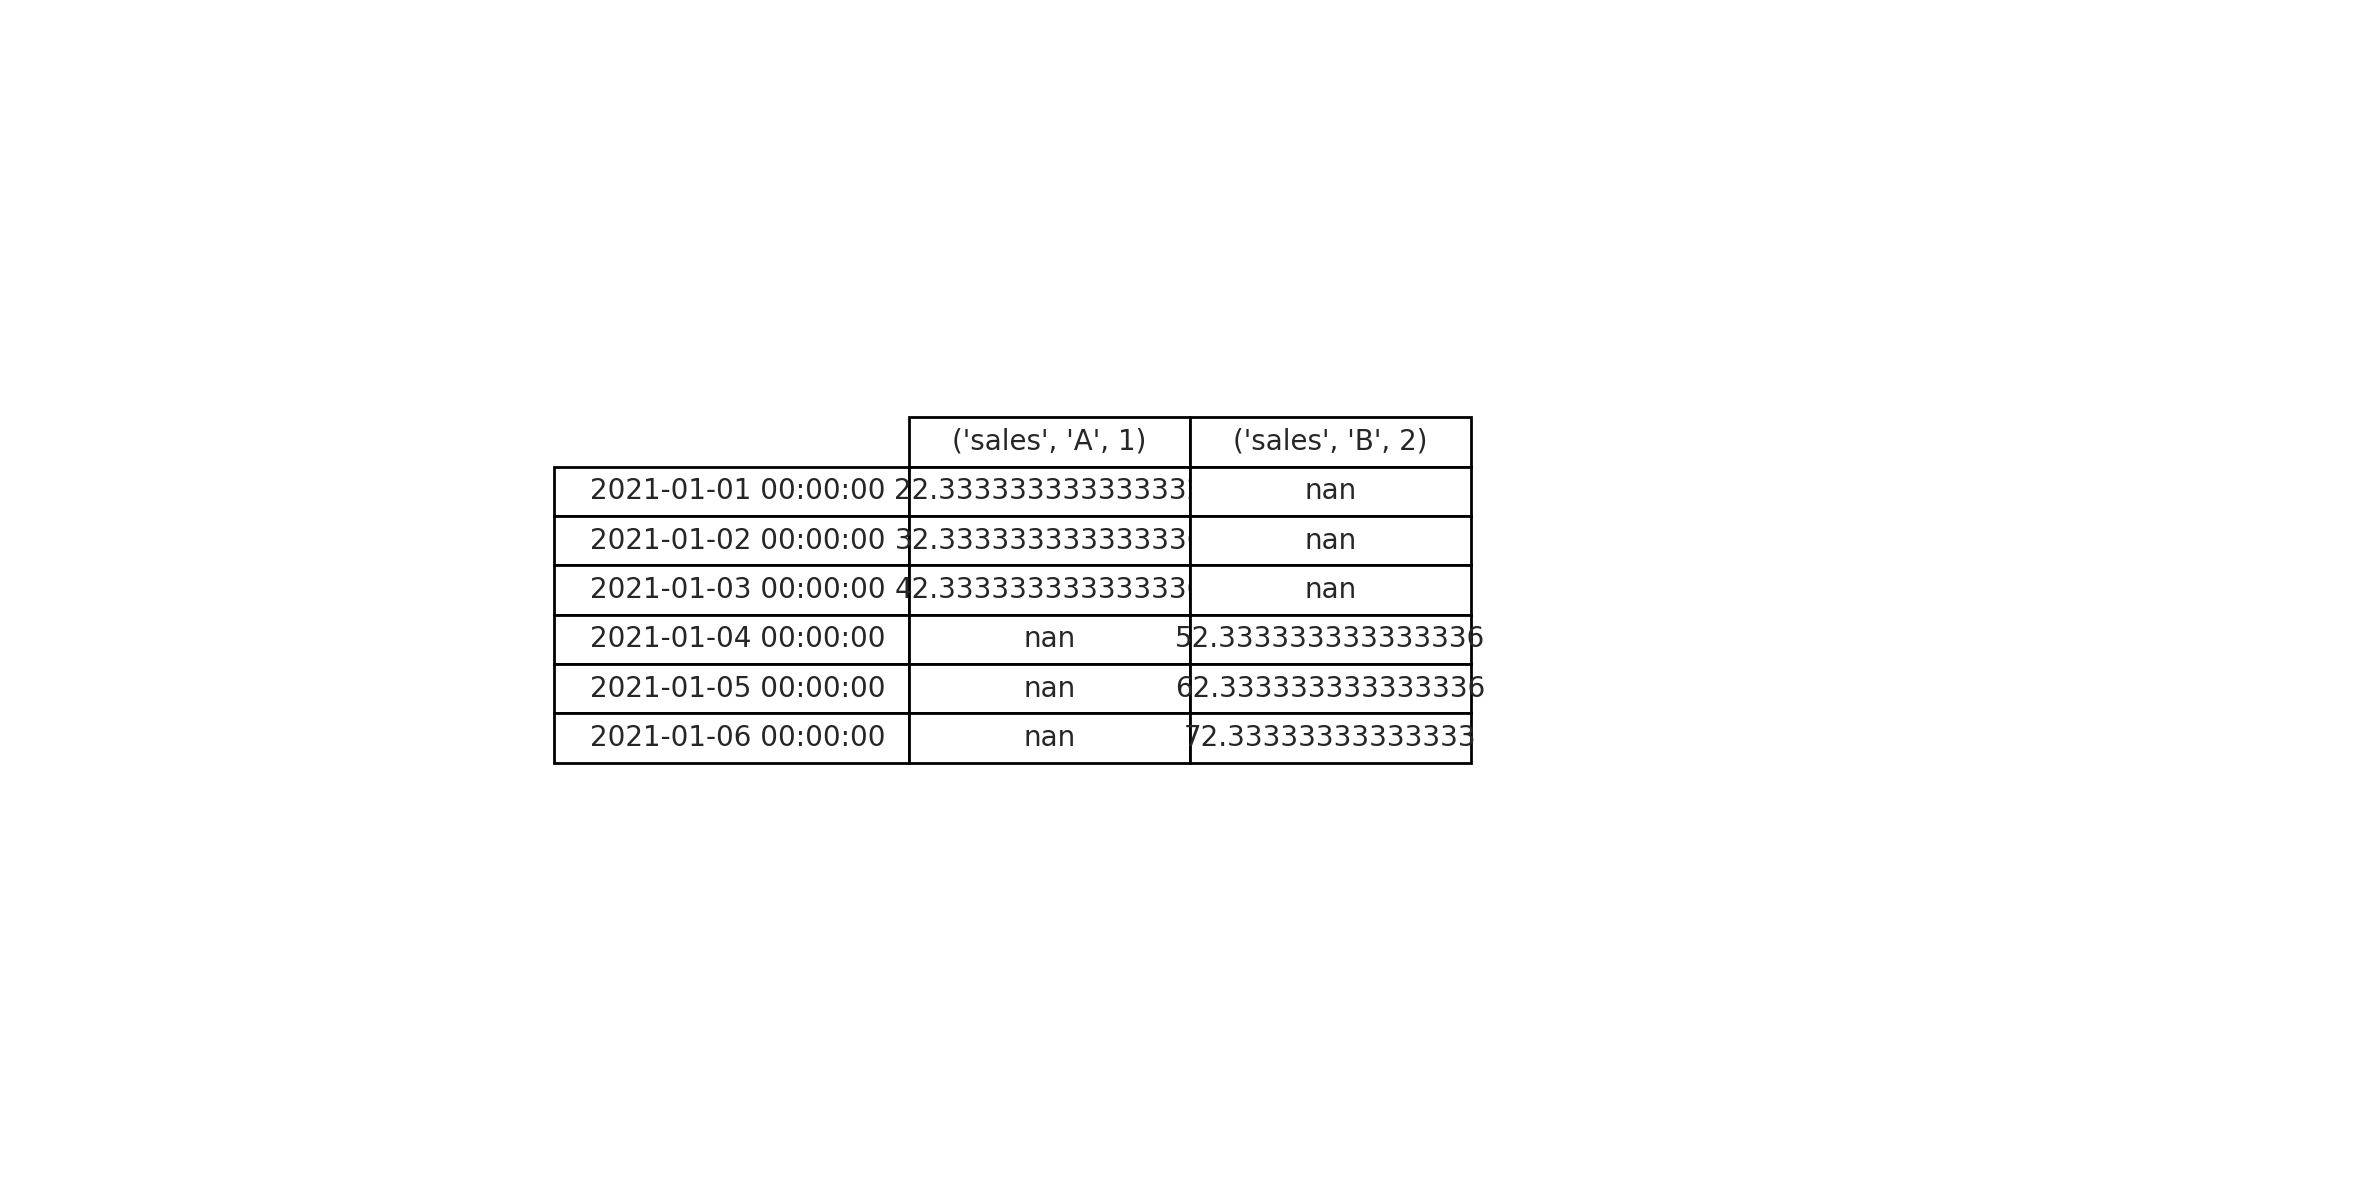

In [16]:
# Ex
# 샘플 데이터 생성
data = {
    'date': pd.date_range(start='2021-01-01', periods=6).tolist() * 3,
    'store_nbr': [1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2],
    'family': ['A', 'A', 'A', 'B', 'B', 'B', 'A', 'A', 'A', 'B', 'B', 'B', 'A', 'A', 'A', 'B', 'B', 'B'],
    'sales': [20, 30, 40, 50, 60, 70, 25, 35, 45, 55, 65, 75, 22, 32, 42, 52, 62, 72]
}
df = pd.DataFrame(data)

# MultiIndex 설정
df.set_index(['date', 'family', 'store_nbr'], inplace=True)

# 중복 항목 평균값으로 집계
df = df.groupby(['date', 'family', 'store_nbr']).mean()

# 데이터 피벗 (Unstack)
wide_df = df.unstack(['family', 'store_nbr'])

# 출력 결과를 표 형식으로 보기 좋게 출력
import matplotlib.pyplot as plt
from pandas.plotting import table

fig, ax = plt.subplots(figsize=(12, 6))  # Plot size 설정
ax.axis('off')  # 축을 끕니다.
tbl = table(ax, wide_df, loc='center', cellLoc='center', colWidths=[0.1]*len(wide_df.columns))
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)  # Scale the table for better fit
plt.show()


# BASELINE SUBMISSION (TREND)
- Public Score (RMSLE): **0.59435**

**Detrend** : 트렌드를 제거하면 데이터에서 장기적인 상승 또는 하락 경향을 제거하여 단기적인 변동 패턴을 더 명확하게

In [17]:
"""
We initiate X_time matrix with 2 columns: 
- the "1" for the regression to count the y-intercept when adjusting weight for this "1"
- a time-dummy to work for detrending
"""

from statsmodels.tsa.deterministic import DeterministicProcess

# DeterministicProcess 초기화
dp = DeterministicProcess(
    index=index_,            # 날짜 인덱스 설정
    constant=True,           # y-절편을 포함하기 위한 상수 항(bias 항)
    order=1,                 # trend를 캡처하기 위한 1차 선형 추
    drop=True,               # 다중 공선성을 피하기 위해 필요시 항을 제거
)

# in_sample 메서드를 사용하여 X_time 행렬 생성
X_time = dp.in_sample()

# 결과 확인
X_time.shape, X_time.isna().sum().sum()
# X_time 행렬의 모양(행, 열)과 결측값(NaN)의 총 개수를 확인합니다.


((1684, 2), 0)

Mean Squared Log Error: 0.32976


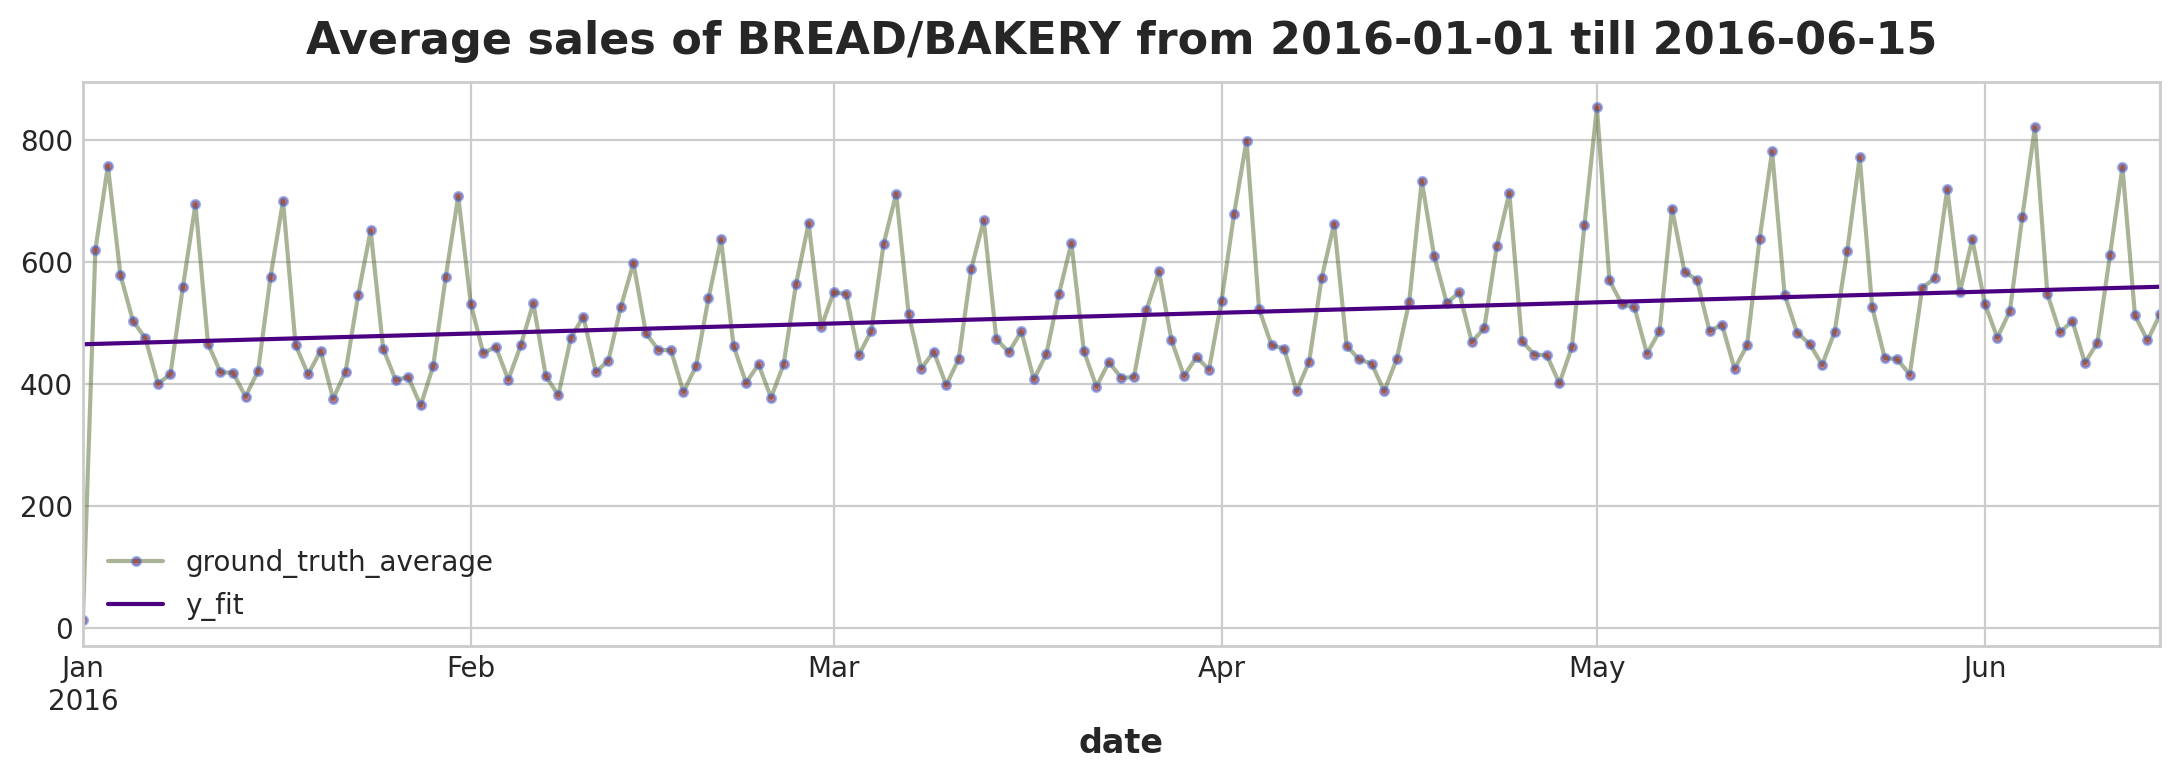

In [18]:
"""
Visualizing fitted curves against average sales (rather than per-family AND per-store) 
in this section is mainly to save trouble replicating the time_dummy across the MultiIndex levels.
"""
check(X_time)

In [ ]:
"""
y_train has a 'wide' format and the model learns to predict not just 1 value, but 1782 at once.
 : wide format으로 모델은 1개를 넘어, 1782개의 값을 예측하는 법을 학습
"""
# base_model = LinearRegression (fit_intercept = False).fit(X_time, y_train)
# joblib.dump(base_model, 'baseline_model.pkl')

In [19]:
# 테스트 세트에 대한 특징 생성
X_time_test = dp.out_of_sample(steps=16)    # 16 step 예측
X_time_test.index.name = 'date'             # 인덱스 이름을 'date'로 설정

In [23]:
# 베이스라인 모델 로드
base_model = joblib.load('/kaggle/input/timeseriescourse-models/baseline_model.pkl')

# 테스트 세트에 대한 예측 수행 및 결과 저장
y_submit = pd.DataFrame(base_model.predict(X_time_test),   # 모델을 사용하여 예측 수행
                        index=X_time_test.index,          # 인덱스를 X_time_test의 인덱스로 설정
                        columns=y_train.columns).clip(0.0) # 예측 결과의 하한을 0으로 설정

# 결과 확인
y_submit.head(5)


family     AUTOMOTIVE                                                    \
store_nbr           1        10        11        12        13        14   
date                                                                      
2017-08-16   4.597808  2.931639  7.779129  6.301972  6.654466  5.075465   
2017-08-17   4.599407  2.931459  7.780422  6.303810  6.655808  5.077195   
2017-08-18   4.601005  2.931280  7.781715  6.305649  6.657149  5.078925   
2017-08-19   4.602604  2.931100  7.783007  6.307488  6.658490  5.080655   
2017-08-20   4.604202  2.930920  7.784300  6.309326  6.659832  5.082384   

family                                              ...    SEAFOOD             \
store_nbr         15        16        17        18  ...          5         50   
date                                                ...                         
2017-08-16  3.546092  5.320532  9.602938  3.549866  ...  11.968824  20.362552   
2017-08-17  3.547115  5.320018  9.607086  3.549560  ...  11.967271  20.358611   
2017-08-18  3.548138  5.319505  9.611233  3.549255  ...  11.965718  20.354670   
2017-08-19  3.549161  5.318992  9.615380  3.548949  ...  11.964164  20.350730   
2017-08-20  3.550184  5.318479  9.619528  3.548643  ...  11.962611  20.346789   

family                                                                     \
store_nbr          51        52        53        54          6          7   
date                                                                        
2017-08-16  56.422467  2.737102  7.890800  1.950650  48.586428  57.019837   
2017-08-17  56.411263  2.739491  7.895550  1.950895  48.592517  57.019189   
2017-08-18  56.400058  2.741880  7.900299  1.951139  48.598606  57.018541   
2017-08-19  56.388853  2.744270  7.905049  1.951384  48.604696  57.017893   
2017-08-20  56.377648  2.746659  7.909799  1.951628  48.610785  57.017245   

family                            
store_nbr           8          9  
date                              
2017-08-16  52.085762  17.491302  
2017-08-17  52.081434  17.492023  
2017-08-18  52.077107  17.492743  
2017-08-19  52.072779  17.493463  
2017-08-20  52.068452  17.494184  

[5 rows x 1782 columns]

In [24]:
submission_0 = (y_submit
            .stack(['family', 'store_nbr'])  # 'family'와 'store_nbr' 인덱스를 스택하여 long 형식으로 변환
            .to_frame()  # 시리즈를 데이터프레임으로 변환
            .join(test.id)  # 'test' 데이터프레임의 'id' 열과 조인
            .rename(columns={0: 'sales'})  # 열 이름을 'sales'로 변경
            .reset_index(drop=True)  # 인덱스를 리셋하고 드롭
            .reindex(columns=['id', 'sales'])  # 'id'와 'sales' 열만 선택하여 재정렬
)

# submission_0.to_csv('/kaggle/working/submission.csv', index=False)

# *A theoretical issue*: **Polynomial Order**
**DeterministicProcess** serves as a useful tool for employing Linear Regression with a polynomial order, 
allowing you to introduce curvature to the linear curve.<br>
But the truth is that the curve with any order, greater than 1 *FREAKS OUT* beyond the training sample.<br>
Think of this: when you 'fit' a LinReg, you adjust weights to the terms of your polynomial and keep them 'in a leash'.<br> 
But when you 'predict', the weights remain the same, while the terms for the new time period grow in the specified order..<br>
Given this behavior, it's challenging for me to find practical use cases for polynomial orders other than "1."<br>
**please share your thoughts in the comments**

 : 1차보다 큰 차로 DP하는건 적용하기 어렵고 사례도 잘 없다.

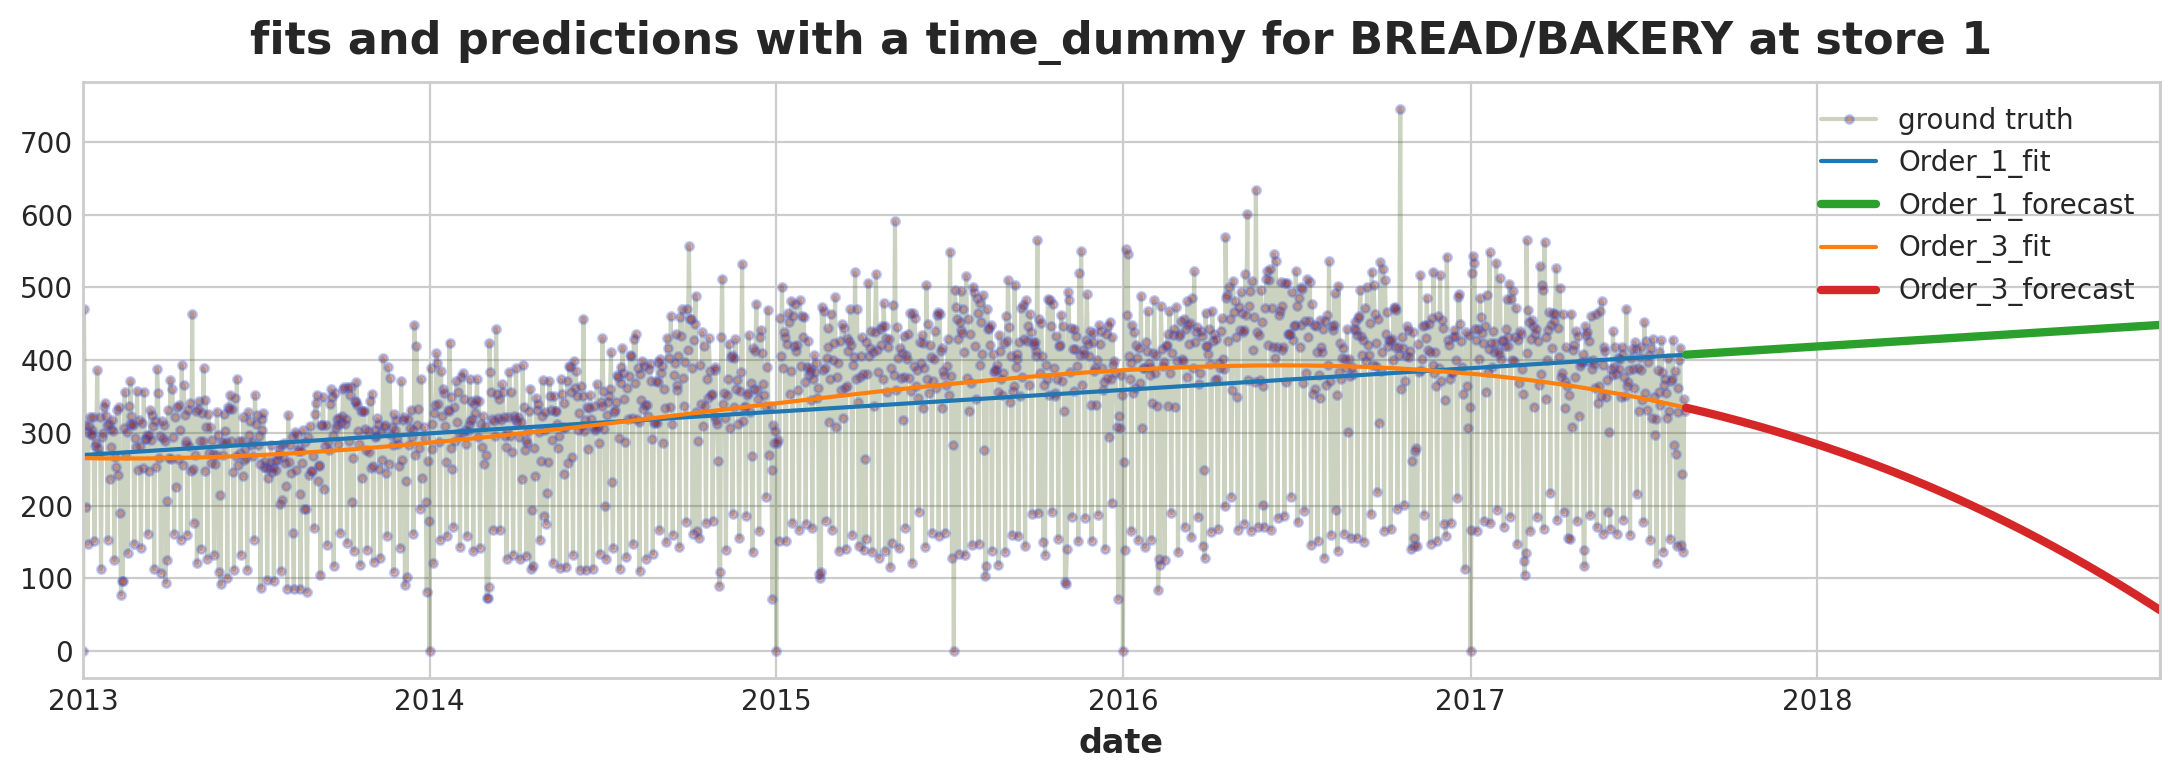

In [25]:
# try different ORDER values to see visualisation of my above statement
ORDER = 3 # 3차

dp_2 = DeterministicProcess(index = index_,
                            constant = True, 
                            order = ORDER, 
                            drop = False)
X_time_1_test = dp.out_of_sample(steps=500)
X_time_n = dp_2.in_sample()
X_time_n_test = dp_2.out_of_sample(steps=500)
demo_model = LinearRegression (fit_intercept = False).fit(X_time_n, y_train)

y_order_1 = pd.DataFrame(base_model.predict(X_time),index = X_time.index,columns = y_train.columns)
y_order_1 = y_order_1.stack([0,1]).to_frame().query('family == @FAMILY and store_nbr == @STORE').reset_index(['family', 'store_nbr'],drop=True).squeeze()

y_order_1_fore = pd.DataFrame(base_model.predict(X_time_1_test),index = X_time_1_test.index,columns = y_train.columns)
y_order_1_fore = y_order_1_fore.stack([0,1]).to_frame().query('family == @FAMILY and store_nbr == @STORE').reset_index(['family', 'store_nbr'],drop=True).squeeze()

y_order_n = pd.DataFrame(demo_model.predict(X_time_n),index = X_time_n.index,columns = y_train.columns)
y_order_n = y_order_n.stack([0,1]).to_frame().query('family == @FAMILY and store_nbr == @STORE').reset_index(['family', 'store_nbr'],drop=True).squeeze()

y_order_n_fore = pd.DataFrame(demo_model.predict(X_time_n_test),index = X_time_n_test.index,columns = y_train.columns)
y_order_n_fore = y_order_n_fore.stack([0,1]).to_frame().query('family == @FAMILY and store_nbr == @STORE').reset_index(['family', 'store_nbr'],drop=True).squeeze()

y_fact = y_train.stack([0,1]).to_frame().query('family == @FAMILY and store_nbr == @STORE').reset_index(['family', 'store_nbr'],drop=True).squeeze()

ax = y_fact.plot (**plot_params, alpha = 0.3, label=f"ground truth")
ax = y_order_1.plot(ax=ax, label="Order_1_fit")
ax = y_order_1_fore.plot(ax=ax, label="Order_1_forecast", color="C2", linewidth = 3)
ax = y_order_n.plot(ax=ax, label=f"Order_{ORDER}_fit")
ax = y_order_n_fore.plot(ax=ax, label=f"Order_{ORDER}_forecast", color="C3", linewidth = 3)
ax.set_title (f'fits and predictions with a time_dummy for {FAMILY} at store {STORE}')
_ = ax.legend()

# SUBMISSION WITH SEASONS ACCOUNTED
- Public Score (RMSLE): **0.53266**

**seasonality**

In [26]:
from scipy.signal import periodogram

# periodogram 세팅
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

Periodogram for BREAD/BAKERY at store 1 from 2016-01-01 till 2016-06-15


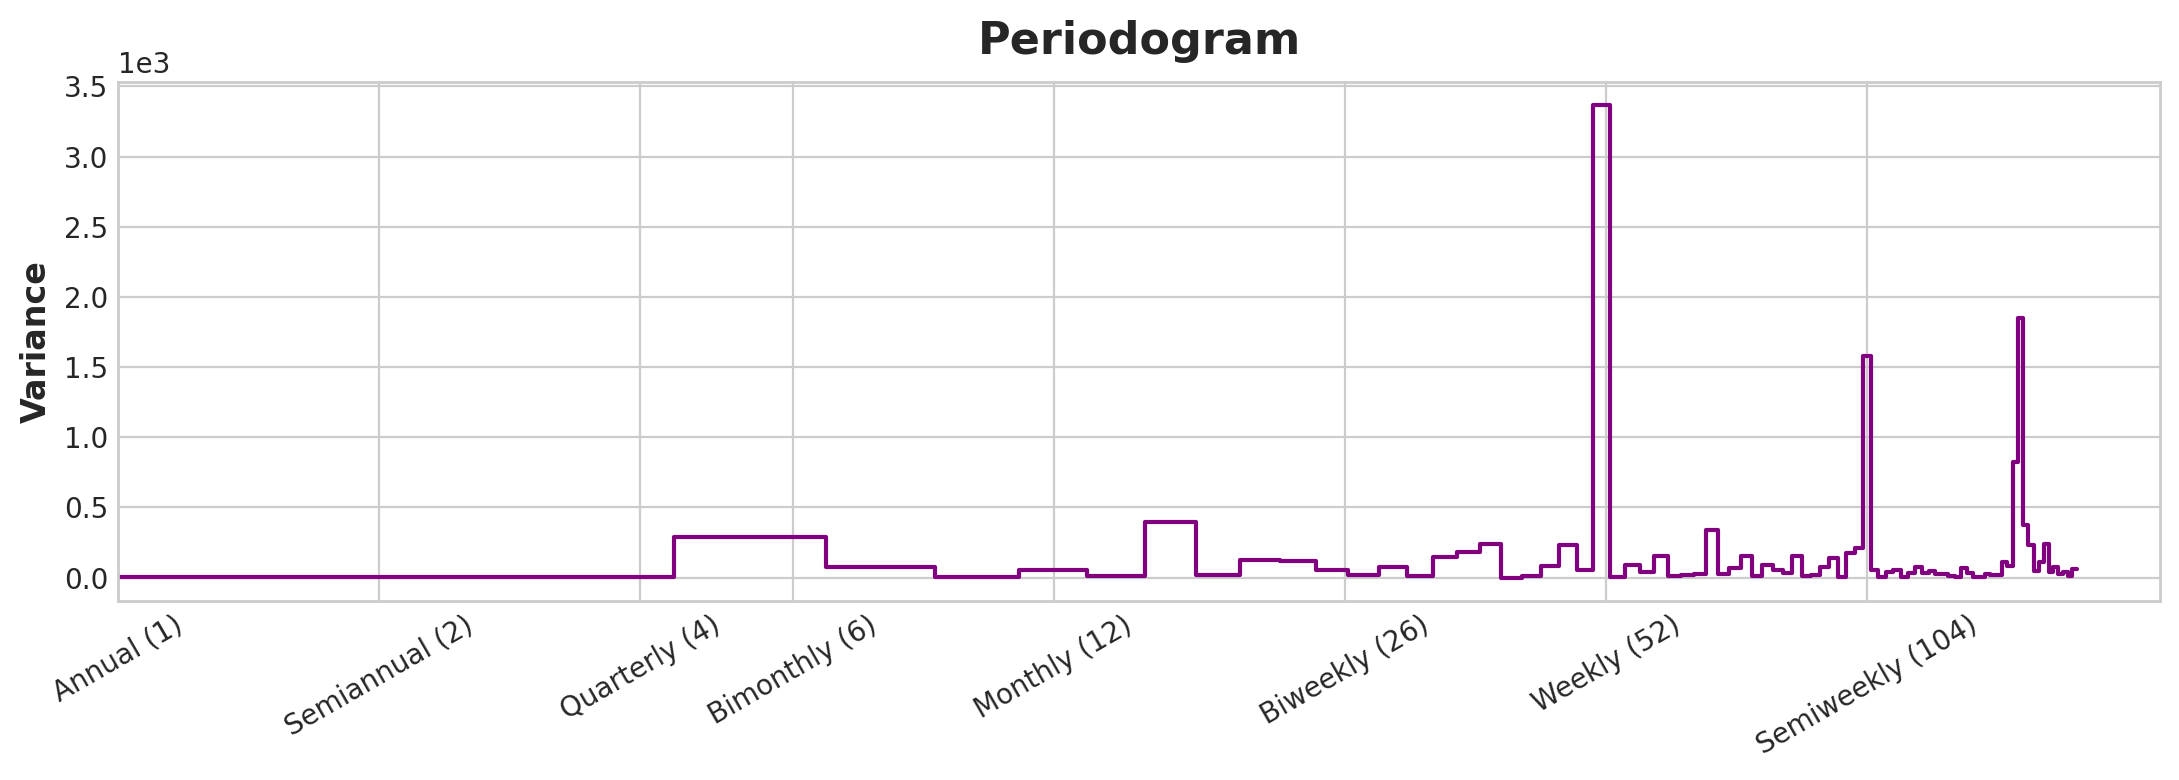

In [27]:
print (f'Periodogram for {FAMILY} at store {STORE} from {START} till {END}')
plot_periodogram(y_true);

## Capture Seasons with day_of_week

In [29]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq}) for {FAMILY} at store {STORE}from {START} till {END}")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

<Axes: title={'center': 'Seasonal Plot (week/day) for BREAD/BAKERY at store 1from 2016-01-01 till 2016-06-15'}, xlabel='day', ylabel='ground_truth'>

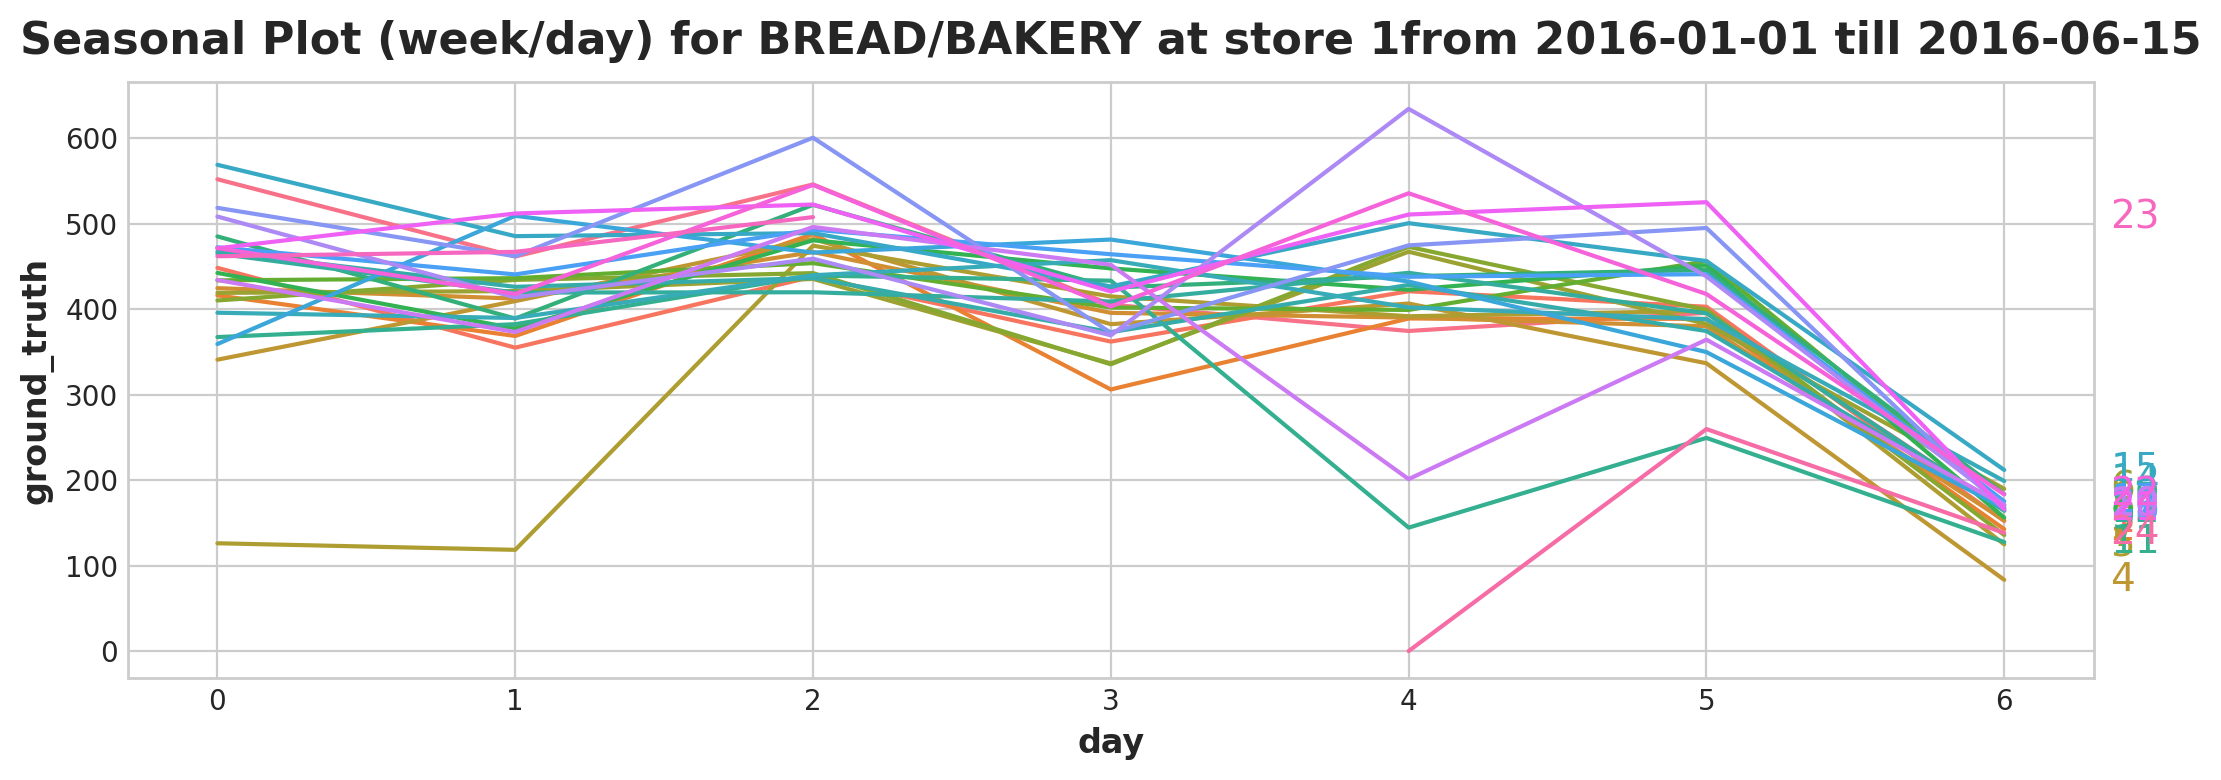

In [31]:
# y_true를 데이터프레임으로 변환
X = y_true.to_frame()

# 데이터프레임에 'day' 열 추가 - 요일 정보 (0: 월요일, 6: 일요일)
X["day"] = X.index.dayofweek

# 데이터프레임에 'week' 열 추가 - 주 정보 (1부터 52까지)
X["week"] = X.index.week

# 시각화를 위한 함수 호출
seasonal_plot(X, y="ground_truth", period="week", freq="day")

In [32]:
# DeterministicProcess를 사용하여 시계열 데이터 생성
X_seasonal = dp.in_sample()

# 요일 정보 생성
day_of_week = pd.Series(X_seasonal.index.dayofweek, index=X_seasonal.index)

# 요일에 대한 원-핫 인코딩 수행
X_day_of_week = pd.get_dummies(day_of_week, prefix='day_of_week')

# 원-핫 인코딩된 요일 정보를 기존 시계열 데이터에 추가
X_seasonal = pd.concat([X_seasonal, X_day_of_week], axis=1)

# 결과 확인
X_seasonal.shape, X_seasonal.isna().sum().sum()

((1684, 9), 0)

Mean Squared Log Error: 0.27609


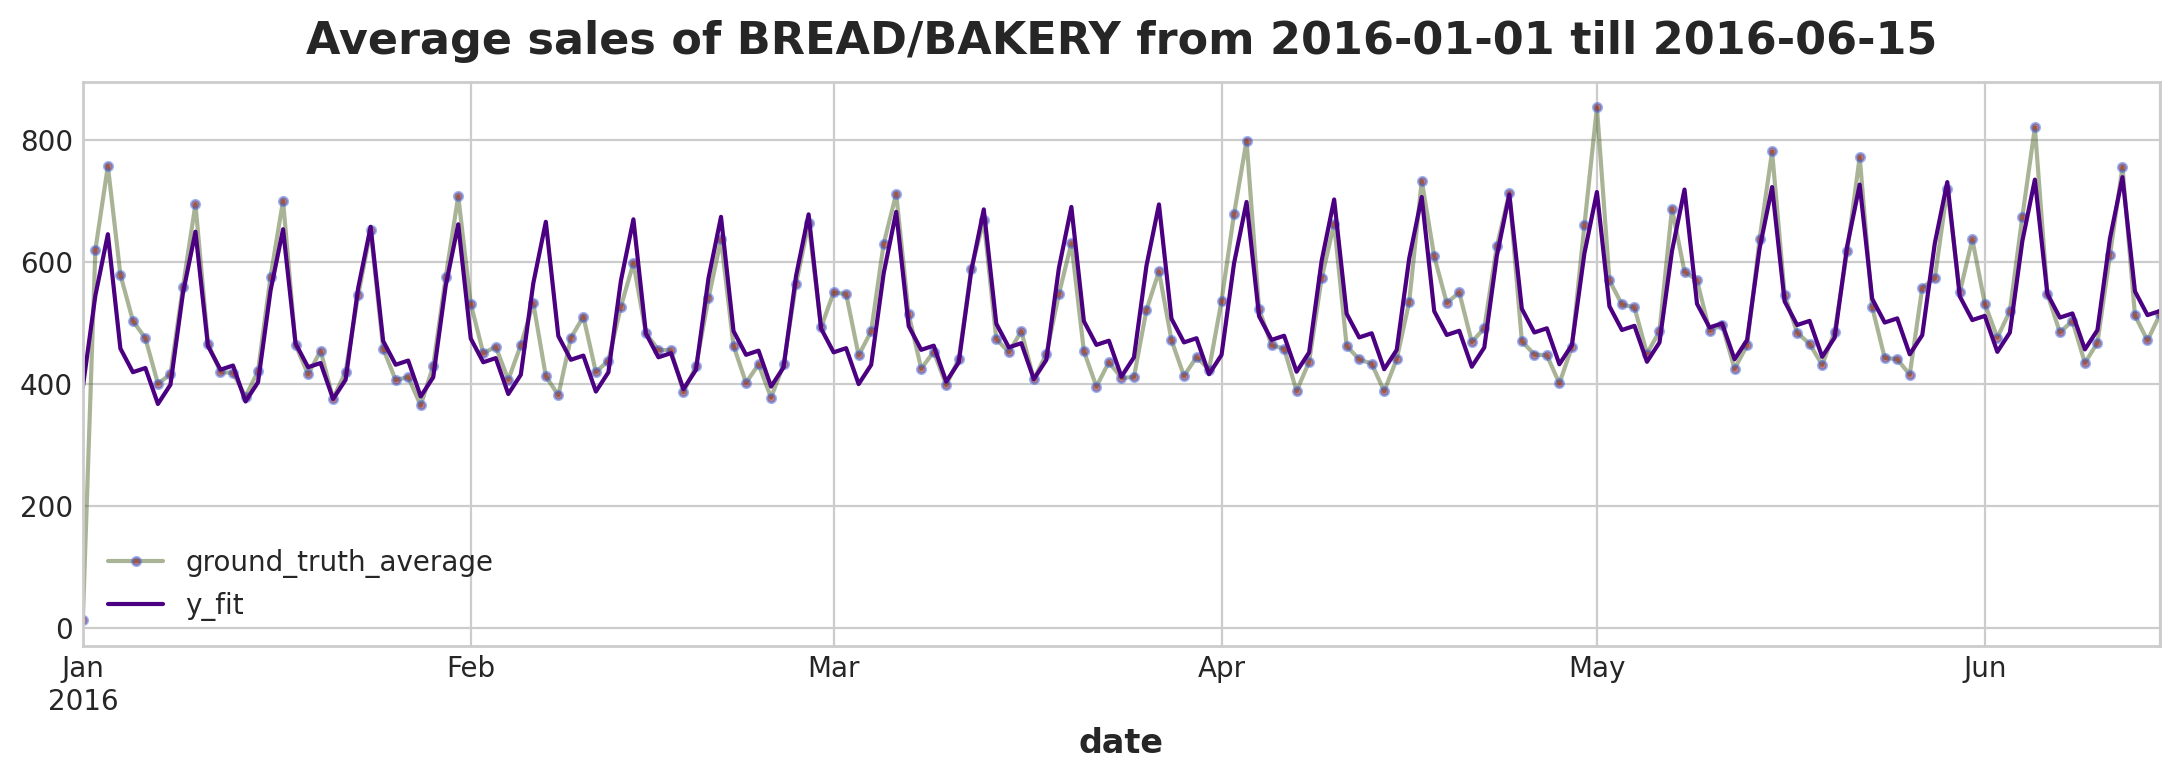

In [33]:
check(X_seasonal)

## Capture Seasons with Fourier

In [34]:
from statsmodels.tsa.deterministic import CalendarFourier

fourier = CalendarFourier(freq="A", order=10)            
dp_fourier = DeterministicProcess(
            index = index_,
            constant=False,             
            order=1,             
            seasonal=True,                                    
            additional_terms=[fourier],     
            drop=True
)
X_fourier = dp_fourier.in_sample()
X_seasonal = pd.concat ([X_seasonal, X_fourier], axis=1)

# Check
X_seasonal.shape, X_seasonal.isna().sum().sum()

((1684, 37), 0)

Mean Squared Log Error: 0.10720


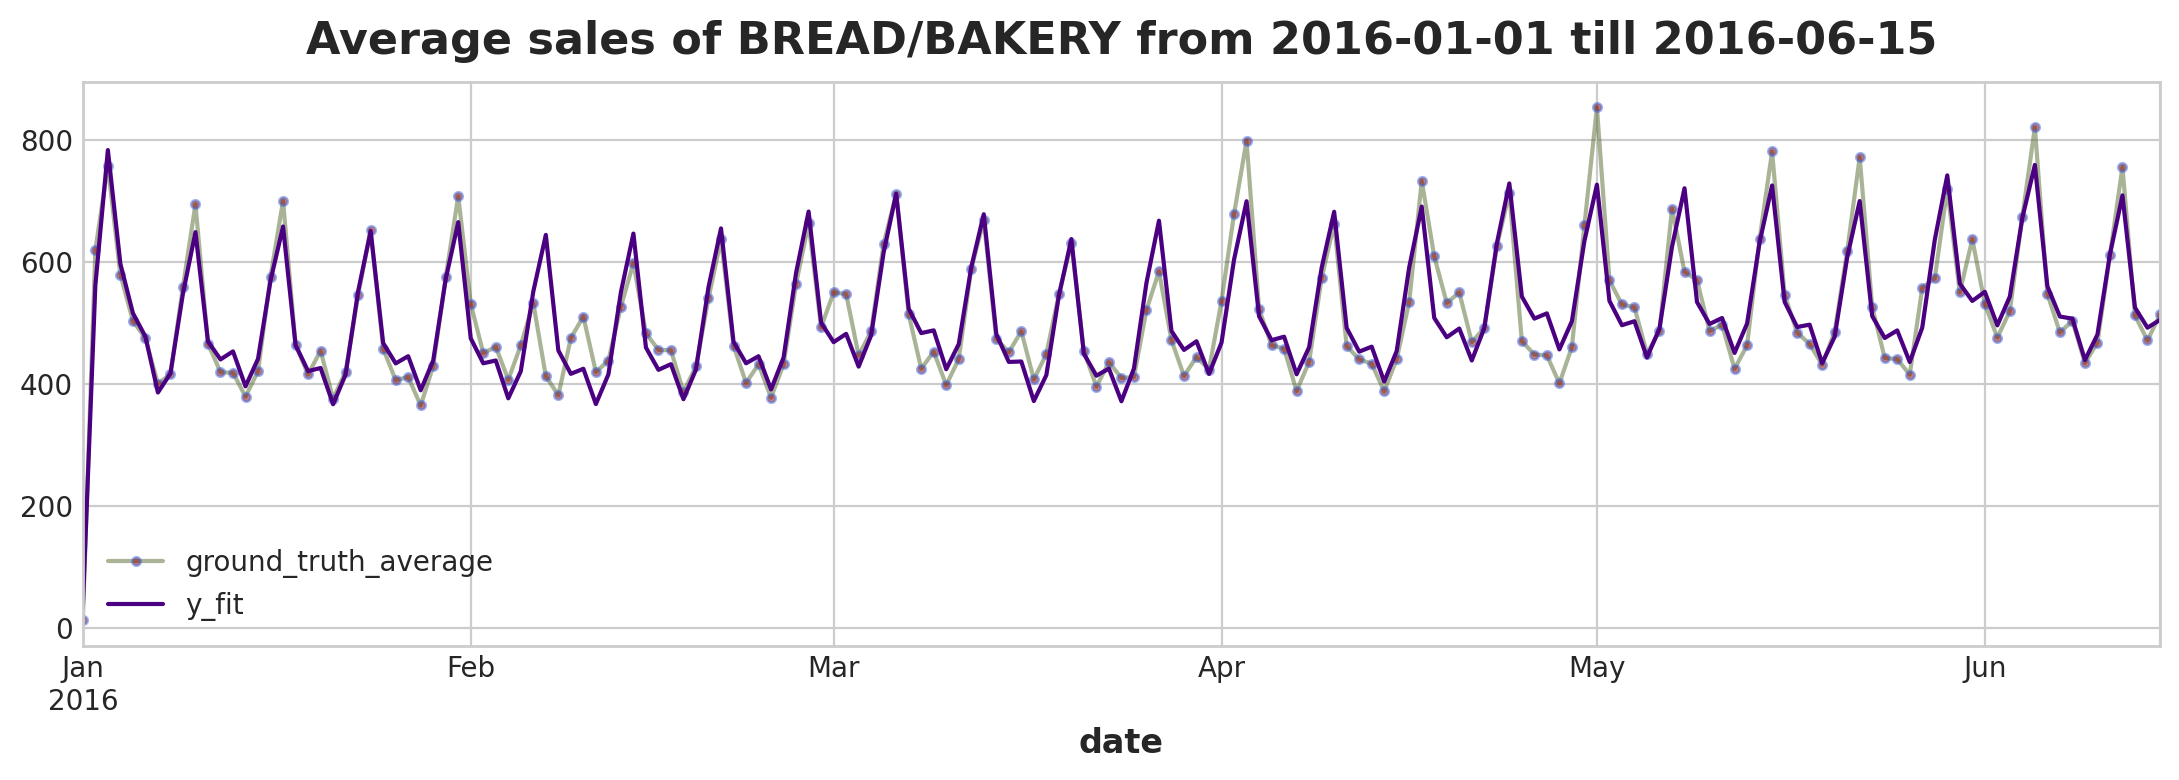

In [35]:
check(X_seasonal)

## Capture Seasons with holidays

*Pay special attention to the 'transferred' column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday.*

* 대체 공휴일(transferred)은 공휴일보단 평일에 가깝다

In [36]:
"""
NOTE: This feature covers New Year.
"""
# holidays_events 데이터프레임에서 특정 조건에 따라 데이터 필터링
holidays = (holidays_events  
            .query("transferred == False")  # 대체 공휴일 제외
            .query("locale == 'National'")  # National 공휴일만 선택
            .loc[:,'description']  # 공휴일 이름을 포함하는 'description' 열만 유지
            .to_frame().assign(description=lambda x: x.description.cat.remove_unused_categories())  # 사용되지 않는 범주 제거
           )

# 중복된 날짜 제거
duplicated_dates = holidays.index.duplicated(keep='first')
holidays = holidays[~duplicated_dates]

# 공휴일 데이터를 원-핫 인코딩
X_holidays = pd.get_dummies(holidays)

# 시계열 데이터프레임에 원-핫 인코딩된 공휴일 정보 추가
X_seasonal = X_seasonal.join(X_holidays, on='date', how='left').fillna(0.0)

# Check
X_seasonal.shape, X_seasonal.isna().sum().sum()

((1684, 109), 0)

Mean Squared Log Error: 0.06497


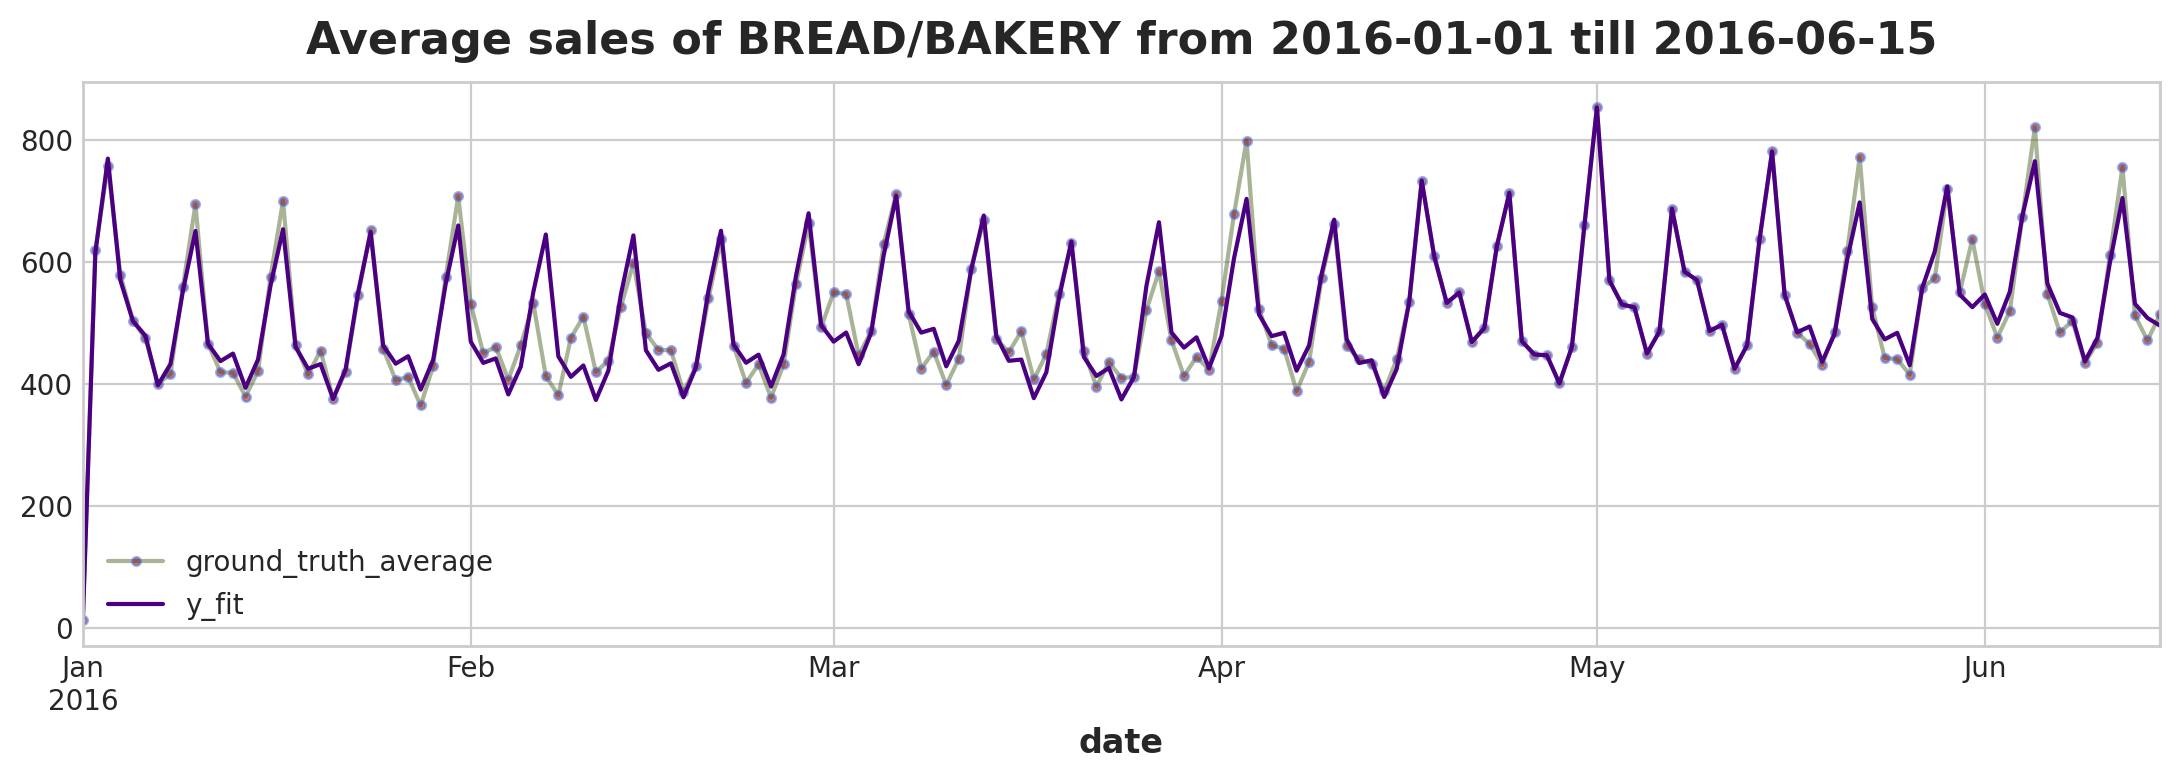

In [37]:
check(X_seasonal)

In [ ]:
# seasonal_model = LinearRegression (fit_intercept = False).fit(X_seasonal, y_train)
# joblib.dump(seasonal_model, 'seasonal_model.pkl')

In [39]:
# 테스트 데이터셋을 위한 피처 생성
X_seasonal_test = dp.out_of_sample(steps=16) # 16 step forecast
X_seasonal_test.index.name = 'date'

# 요일 정보를 사용한 deseason
day_of_week = pd.Series(X_seasonal_test.index.dayofweek, index=X_seasonal_test.index)
X_day_of_week = pd.get_dummies(day_of_week, prefix='day_of_week')
X_seasonal_test = pd.concat([X_seasonal_test, X_day_of_week], axis=1)

# Fourier 변환을 사용한 deseason
X_fourier_test = dp_fourier.out_of_sample(16)
X_seasonal_test = pd.concat([X_seasonal_test, X_fourier_test], axis=1)

# 공휴일 정보를 사용한 deseason
X_seasonal_test.index.name = 'date'
X_seasonal_test = X_seasonal_test.join(X_holidays, on='date', how='left').fillna(0.0)

X_seasonal_test.head()


,const,trend,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,trend,...,description_Terremoto Manabi+5,description_Terremoto Manabi+6,description_Terremoto Manabi+7,description_Terremoto Manabi+8,description_Terremoto Manabi+9,description_Traslado Batalla de Pichincha,description_Traslado Independencia de Guayaquil,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1.0,1685.0,False,False,True,False,False,False,False,1685.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-17,1.0,1686.0,False,False,False,True,False,False,False,1686.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-18,1.0,1687.0,False,False,False,False,True,False,False,1687.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-19,1.0,1688.0,False,False,False,False,False,True,False,1688.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-20,1.0,1689.0,False,False,False,False,False,False,True,1689.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
seasonal_model = joblib.load('/kaggle/input/timeseriescourse-models/seasonal_model.pkl')
y_seasonal_fore = pd.DataFrame(seasonal_model.predict(X_seasonal_test),               
                        index = X_seasonal_test.index,      
                        columns = y_train.columns).clip(0.0)

In [41]:
submission_1 = (y_seasonal_fore
            .stack(['family', 'store_nbr'])
            .to_frame()
            .join(test.id)
            .rename(columns = {0:'sales'})
            .reset_index(drop=True)
            .reindex(columns = ['id','sales'])
            )
# submission_1.to_csv('/kaggle/working/submission.csv', index=False)

# SUBMISSION WITH VULCANO
- Public Score (RMSLE): **0.53218** (best result)

*A magnitude 7.8 earthquake struck Ecuador on `April 16, 2016`. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake*

* 에콰도르 진도 7.8 지진 직후, 슈퍼마켓 매출 급증

## Add OHE for Eruption with 21-lags

In [42]:
# 래그 피처를 생성하는 함수 정의
def make_lags(ts, lags, prefix=None):
    return pd.concat({
            f'{prefix}_lag_{i}': ts.shift(i)  # 각 래그 피처의 열 이름을 생성하고 시프트
            for i in lags  # 지정된 래그 범위 내에서 반복
        },
        axis=1)  # 열 방향으로 결합

# 특정 날짜에 이벤트 발생 여부를 나타내는 데이터프레임 생성
vulcano = pd.DataFrame((X_time.index == '2016-04-16') * 1.0, index=index_, columns=['vulcano'])
# '2016-04-16'에 이벤트가 발생한 경우 1.0, 그렇지 않으면 0.0으로 설정

# vulcano 이벤트의 래그 피처 생성
X_vulcano_ = make_lags(vulcano.squeeze(), lags=range(22), prefix='vulcano')
# make_lags 함수를 사용하여 0부터 21까지의 래그 피처를 생성

# 결측값을 0으로 채움
X_vulcano_ = X_vulcano_.fillna(0.0)
# 생성된 래그 피처에서 결측값을 0으로 채움

# Check
# start = pd.Period('2016-04-16', freq='D')
# X_vulcano.loc[start:start+21]

In [43]:
X_vulcano = pd.concat([X_seasonal, X_vulcano_], axis = 1)
X_vulcano.shape, X_vulcano.isna().sum().sum()

((1684, 131), 0)

In [44]:
X_vulcano.head()

,const,trend,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,trend,...,vulcano_lag_12,vulcano_lag_13,vulcano_lag_14,vulcano_lag_15,vulcano_lag_16,vulcano_lag_17,vulcano_lag_18,vulcano_lag_19,vulcano_lag_20,vulcano_lag_21
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,False,True,False,False,False,False,False,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,1.0,2.0,False,False,True,False,False,False,False,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,1.0,3.0,False,False,False,True,False,False,False,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-04,1.0,4.0,False,False,False,False,True,False,False,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-05,1.0,5.0,False,False,False,False,False,True,False,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Mean Squared Log Error: 0.06497


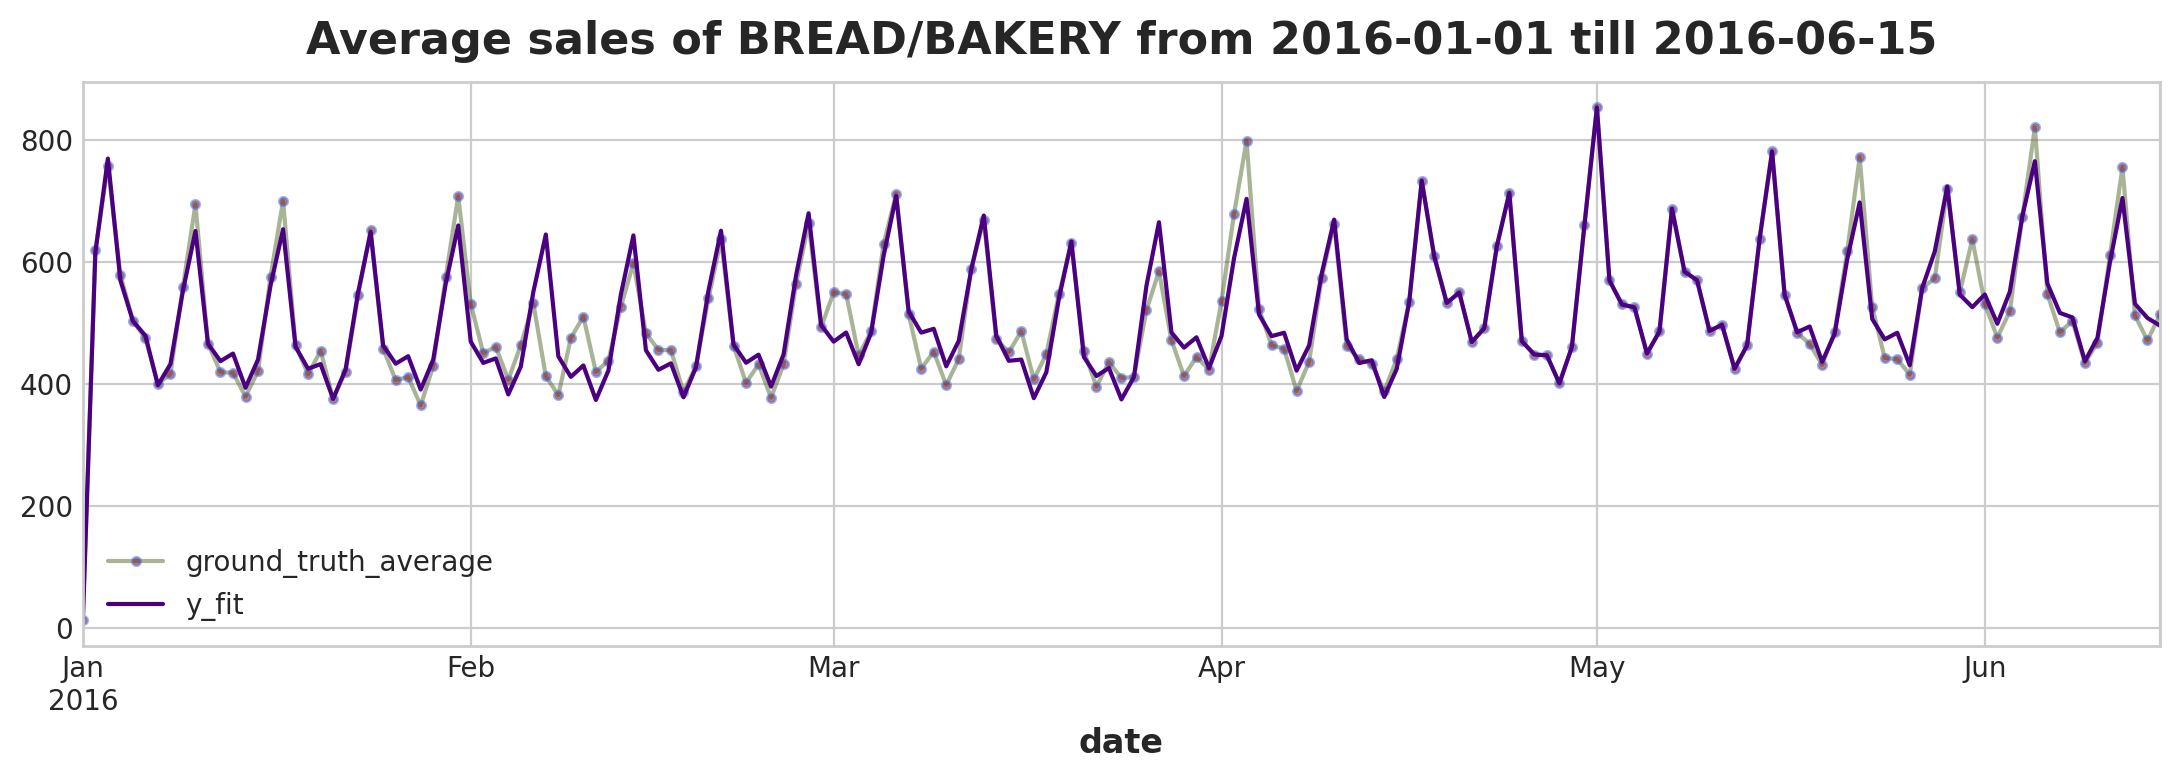

In [45]:
check(X_vulcano)

In [ ]:
# vulcano_model = LinearRegression (fit_intercept = False).fit(X_vulcano, y_train)
# joblib.dump(vulcano_model, 'vulcano_model.pkl')

In [46]:
# add vulcano to the test set
X_vulcano_test = X_seasonal_test.join(X_vulcano_, on='date', how='left')
X_vulcano_test = X_vulcano_test.fillna(0.0)

X_vulcano_test.shape, X_vulcano_test.isna().sum().sum()

((16, 131), 0)

In [47]:
vulcano_model = joblib.load ('/kaggle/input/timeseriescourse-models/vulcano_model.pkl')
y_vulcano_fore = pd.DataFrame(vulcano_model.predict(X_vulcano_test),               
                        index = X_vulcano_test.index,      
                        columns = y_train.columns).clip(0.0)

In [48]:
submission_2 = (y_vulcano_fore
            .stack(['family', 'store_nbr'])
            .to_frame()
            .join(test.id)
            .rename(columns = {0:'sales'})
            .reset_index(drop=True)
            .reindex(columns = ['id','sales'])
            )
#best score
submission_2.to_csv('/kaggle/working/submission.csv', index=False)

# 체크포인트

# SUBMISSION WITH MULTISTEP TARGET
- Public Score (RMSLE): **0.55745**

The training set ends on `2017-08-15`, which gives us the forecast **origin**.<br> The test set comprises the dates `2017-08-16` to `2017-08-31`, and this gives us the **forecast horizon**. <br>
There is one step between the origin and horizon, so we have a **lead time of one day**. <br>Put another way, we need a *`16-step forecast with a 1-step lead time`*.

# *A theoretical issue*: **Algorithm's Complexity**
Remember we said that to deal with temporal dependence with LinReg you need **X** and **y** that have simple PeriodIndex in axis=1. All other categories go 'wide' (axis=0). I think of this in a way that one row should contain everything that happened that day. <br>

Now, in our data set we have 54 stores and 33 'families' which brings us to their product - **1782** values per row in our initial BASELINE setting.<br>

What happens when we introduce multistep target? Exectly! We should multiply that number by the number of the steps. If we take 16 steps-forecast, then we will end up with **28 512** values per row, essentially meaning, that we will run **28 512** different regressions. 1 month forecast will cost us **53 460** parallel regressions at a time.

If I'm not mistaken, the Complexity of this algorithm can be described as:<br> 
                            
                            O(n*m*k)
                               
where:<br>
`n` - number of categorical features<br>
`m` - number of categories in each of the features <br>
`k` - number of your shifted features (lags, leads, rolling statistics)

In order to shrink down the numbers, you have 3 straightforward options:
1. Reduce `n` by averaging across some categories 
2. Reduce `m` by more coarse grouping
2. Reduce the number of steps in the forecast.

While 1. and 2. may be just meaningless, we will talk about №3 in the section **`Complexity Vs Error Propagation`**

4. An alternative approach involves reducing dimensionality using __Single Value Decomposition (SVD)__, such as PCA and TruncatedSVD. While these methods are powerful, they introduce challenges related to result interpretation and monitoring data loss. This is a complex topic that can be explored in depth in another notebook.

In [ ]:
# Off top: check this series for more on SVD
from IPython.display import HTML
youtube_video_id = "nbBvuuNVfco?si=zAxPfuv4OXiBbgyI"
HTML(f'<iframe width="300" height="250" src="https://www.youtube.com/embed/{youtube_video_id}" frameborder="0" allowfullscreen></iframe>')

In [ ]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

def check_multistep (
            data,    
            y = y_train,
            START = START, 
            END = END,
            FAMILY = FAMILY,
            STORE = STORE,
            EVERY = 16
):
       
    fit = (data
           .stack(['family', 'store_nbr'])
           .query('family == @FAMILY and store_nbr == @STORE')
           .reset_index(['family', 'store_nbr'], drop=True)
           .loc[START:END]
          )

    y = (y
         .stack(['family', 'store_nbr'])
         .to_frame()
         .query('family == @FAMILY and store_nbr == @STORE')
         .reset_index(['family', 'store_nbr'],drop=True)
         .rename(columns={0:'ground_truth'})
         .loc[START:END]
         .squeeze()
        )

    fig, ax = plt.subplots(1, 1, figsize=(11, 4))
    ax = y.plot(**plot_params, ax=ax, alpha=0.5)
    ax = plot_multistep(fit, ax=ax, every=EVERY)
    ax.set_title (f'16-days forecasts against ground-truth for {FAMILY} from {START} till {END}')
    
# Takes one forecast on START day and renames all 'lag_{i}' columns by corresponding dates.     
def fetch_forecast (
        data,
        START = '2017-08-16',
        END = '2017-08-31'):
    
    X = data.loc[START]
    DATES = pd.period_range (START, END)                                # this is needed for iteration through a list of all 
    index_to_rename = X.index.get_level_values(0).unique()[:len(DATES)] # dates in the horizon (when calculating an average)
    rename_dict = dict(zip(index_to_rename, DATES))

    forecast = X.rename(rename_dict, level = 0).to_frame()
    forecast.index = forecast.index.set_names('date',level = 0)
    
    return forecast

In [ ]:
# It gets shorter after dropping NANs. Hence are all further '.align()' methods
y_train_multi = make_multistep_target(y_train, steps=16).dropna() 

In [ ]:
y_train_multi, X_vulcano_cut = y_train_multi.align(X_vulcano, join='inner', axis=0)

In [ ]:
# X_vulcano_cut has 'const' column, which works to calculate y-intercept
# model_multi = LinearRegression (fit_intercept = False).fit(X_vulcano_cut, y_train_multi)
# joblib.dump(model_multi, "model_multi.pkl")

In [ ]:
model_multi = joblib.load('/kaggle/input/timeseriescourse-models/model_multi.pkl')
y_multi_fit = pd.DataFrame(model_multi.predict(X_vulcano_cut),               
                        index = X_vulcano_cut.index,      
                        columns = y_train_multi.columns).clip(0.0)

In [ ]:
check_multistep (y_multi_fit)

In [ ]:
y_multi_fore = pd.DataFrame(model_multi.predict(X_vulcano_test),               
                        index = X_vulcano_test.index,      
                        columns = y_train_multi.columns).clip(0.0)

In [ ]:
submission_3 = (fetch_forecast(y_multi_fore)
                  .join(test.id)
                  .reset_index(drop=True)
               )

submission_3['sales'] = submission_3.iloc[:,0]
submission_3 = submission_3[['id','sales']]
# submission_3.to_csv('/kaggle/working/submission.csv', index=False)

## Bonus: forecasts averaged
- Public Score (RMSLE): **0.55769** (no improvement)

In [ ]:
'''
This is where we iterate through a list of dates, fetching forecasts and renaming their 
'lag_{i}' columns with pertinent dates
'''
range_ = [str(period) for period in pd.period_range ('2017-08-16', '2017-08-31')]
forecasts = [fetch_forecast (y_multi_fore, START=i) for i in range_]

In [ ]:
# Nice tool from the course. Here is how it may be applied
import ipywidgets as widgets

data_tabs = widgets.Tab([widgets.Output() for _ in enumerate(forecasts)])
for i, df in enumerate(forecasts):
    data_tabs.set_title(i, f'forecast {i+1}')
    with data_tabs.children[i]:
        display(df)

display(data_tabs)

In [ ]:
full = forecasts[0]

for forecast in forecasts[1:]:
    full = full.merge(forecast, left_index=True, right_index=True, how='left')

submission_4 = pd.DataFrame (full.mean(axis=1), columns = ['sales'])
submission_4 = submission_4.join(test.id).reset_index(drop=True)
# submission_4.to_csv('/kaggle/working/submission.csv', index=False)

# SUBMISSION WITH BOOSTED HYBRID
- Public Score (RMSLE): **0.55867**

In [ ]:
"""
While the linear regression algorithm is capable of multi-output regression, 
the XGBoost algorithm is not. To predict multiple series at once with XGBoost, 
we'll instead convert these series from wide format, with one time series per column, 
to long format, with series indexed by categories along rows.
"""

class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method
        
    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)
        y_fit = pd.DataFrame(                          # make predictions with self.model_1
                    self.model_1.predict(X_1),
                    index=X_1.index, 
                    columns=y.columns
        )
        y_resid = y - y_fit                             # compute residuals
        y_resid = y_resid.stack([0,1])                  # wide to long. (level=[0,1]) - to pivot both 'family' and 'store_nbr'
        
        X_2_train, X_2_val, y_resid_train, y_resid_val = train_test_split(X_2, y_resid, test_size=0.2, shuffle=False)

        self.model_2.fit(X_2_train, y_resid_train,     # fit self.model_2 on residuals
                         early_stopping_rounds=5,      # This is an XGB feature
                         eval_set=[(X_2_val, y_resid_val)], # that works in pair with this one
                         verbose=False)

        self.y_columns = y.columns                     # Save column names for predict method
        self.y_fit = y_fit                             # Save data
        self.y_resid = y_resid
        
        
    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, 
            columns=self.y_columns,
        )
        y_pred = y_pred.stack([0,1])
        y_pred += self.model_2.predict(X_2)
        
        return y_pred

In [ ]:
'''
As soon as we have 'early_stopping' hyperparameter for XGB, 
the value of 'n_estimators' becomes less significant. 
'''
model_BH = BoostedHybrid(
            model_1=LinearRegression(fit_intercept = False),
            model_2=XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
)

In [ ]:
"""
So that XGBoost can learn to distinguish between FAMILIES and STORES, 
we'll duplicate these levels of MultiIndex with categorical features with a label encoding. 
"""

from sklearn.preprocessing import LabelEncoder

X_2 = train[['onpromotion']]

le_family = LabelEncoder()
X_2['family_fact'] = X_2.index.get_level_values('family')
X_2['family_fact'] = le_family.fit_transform(X_2['family_fact'])
X_2['store_fact'] = X_2.index.get_level_values('store_nbr').astype(int)

In [ ]:
X_2_test = test[['onpromotion']]

X_2_test['family_fact'] = X_2_test.index.get_level_values('family')
X_2_test['family_fact'] = le_family.transform(X_2_test['family_fact'])
X_2_test['store_fact'] = X_2_test.index.get_level_values('store_nbr').astype(int)

In [ ]:
# model_BH.fit(X_vulcano, X_2, y_train)
# joblib.dump (model_BH, 'BoostedHybrid.pkl')

In [ ]:
model_BH = joblib.load('/kaggle/input/timeseriescourse-models/BoostedHybrid.pkl')
y_BH_fit = model_BH.predict(X_vulcano, X_2).to_frame().clip(0.0)

In [ ]:
"""
Here we pass the models' fit TO the ckeck() function, 
so no fitting INSIDE of the function is required.
"""
check (y_BH_fit, 
       y = y_train, 
       STORE = STORE, 
       FIT=False, 
       Prefix = f'BOOSTED HYBRID Model fit')

In [ ]:
y_BH_fore = model_BH.predict(X_vulcano_test, X_2_test).clip(0.0)

In [ ]:
submission_5 = (y_BH_fore 
            .to_frame()
            .join(test.id)
            .rename(columns = {0:'sales'})
            .reset_index(drop=True)
            .reindex(columns = ['id','sales'])
            )
# submission_5.to_csv('/kaggle/working/submission.csv', index=False)

# SUBMISSION WITH STACKED HYBRID
- Public Score (RMSLE): **0.53234**

In [ ]:
''' 
It's similar to the boosted model above, with one key difference: 
We include model_1's prediction as a feature in X_2_train instead of subtracting it from y_train.
'''
class StackedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method
        
    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)
        y_fit = pd.DataFrame(                          
                    self.model_1.predict(X_1),
                    index=X_1.index, 
                    columns=y.columns
        )
    
        y_long = y_fit.stack(level=[0,1])              
        
        X_2 = pd.concat([X_2, y_long], axis=1)         # HERE IS WHY THE MODEL IS STACKED
            
        X_2_train, X_2_val, y_long_train, y_long_val = train_test_split(X_2, y_long, test_size=0.2, shuffle=False)

        self.model_2.fit(X_2_train, y_long_train,     
                         early_stopping_rounds=3,       
                         eval_set=[(X_2_val, y_long_val)], 
                         verbose=False)

        self.y_columns = y.columns                    
        self.y_fit = y_fit                           
        self.y_long = y_long
        
        
    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, 
            columns=self.y_columns,
        )
        y_pred = y_pred.stack([0,1])
        
        X_2_augm = pd.concat([X_2, y_pred], axis=1)
        
        y_pred_2 = pd.Series(
            self.model_2.predict(X_2_augm),
            index=X_2.index)
        
        return y_pred_2

In [ ]:
model_SH = StackedHybrid(
            model_1=LinearRegression(fit_intercept = False),
            model_2=XGBRegressor(n_estimators = 50, learning_rate=0.05, n_jobs=4)
)

In [ ]:
# model_SH.fit(X_vulcano, X_2, y_train)
# joblib.dump (model_SH, 'StackedHybrid.pkl')

In [ ]:
model_SH = joblib.load('/kaggle/input/timeseriescourse-models/StackedHybrid.pkl')
y_stacked_hybrid_fit = (model_SH
                    .predict(X_vulcano, X_2)
                    .to_frame()
                    .rename(columns = {0: 'STACKED HYBRID fit'})
                   )

In [ ]:
"""
Boosted Hybrid looked better
"""
check (y_stacked_hybrid_fit, 
       y = y_train, 
       STORE = STORE, 
       FIT = False,
       Prefix = f'STACKED HYBRID Model fit'
      )

In [ ]:
y_stacked_hybrid = model_SH.predict(X_vulcano_test, X_2_test).clip(0.0)

In [ ]:
submission_6 = (y_stacked_hybrid
            .to_frame()
            .join(test.id)
            .rename(columns = {0:'sales'})
            .reset_index(drop=True)
            .reindex(columns = ['id','sales'])
            )
# submission_6.to_csv('/kaggle/working/submission.csv', index=False)

# SUBMISSION WITH BOOSTED HYBRID AND MULTISTEP TARGET
- Public Score (RMSLE): **0.79814**

# *A theoretical issue*: **Complexity Vs Error Propagation**

**four common strategies**
The course introduces 4 theoretical consepts of forecasting:<br>
*Multioutput model, Direct Strategy, Recursive Strategy* and *DirRec Strategy*.

In my humble opinion, there are only two real concepts here:

1. `Multioutput model` and `Direct Strategy` **is the same thing**. Even if we make one .fit() in our code, we are still running as many models as there are steps in `y`. No matter what model we use. Even Neural Networks in their multiple outputs produce destribution of a probability (which is 1 destributed among all the classes). No model can give you several UNRELATED values in an output. Otherwise, how should your Error Function work? **Please, correct me if I am wrong**

2. `Recursive Strategy` and `DirRec Strategy` is also **the same thing**. You give a forecast as input to your model to make a new forecast. The difference is how many steps your `y` has, how many you give the model at a time. If one - it's *recursive*, if several - it's *DirRec*. In my humble opinion, it is the same strategy and the number of steps is just a Complexity Vs Error compromise, informed by computation resourses at your disposale.

**Error Propagation**
When you pass a LinReg's own prediction as an input to itself multiple times, you can calculate the error accumulation as a progression. This allows you to create a statistically supported Confidence Interval for your forecast. However, if you do the same with XGBoost, you can't estimate the accumulated error because XGBoost doesn't rely on functional dependencies. It only knows that when `X` is **A**, `y` should be somewhere close to **B** and when `X` is **A1**, `y` should be somewhere close to **B2**. The difference between A1 and A2 may be very small, and the difference between B1 and B2 can be significant, and it won't be the same for the next interval. So when your erroneous input randomly assumes the value of A2, your model's output goes crazy. And then you feed that sick output back to the model for the next prediction. 

My assumption is that error propagation with XGBoost is unpredictable or ridiculously complex to control. And this is why you would want to avoid or at least minimize it as much as possible.

How can you do that? By reducing the number of fits with forecasts. And here comes the **trade off**:
1. Idially, you would want your model to produce a forecast for the entire horizon (all 16 days at once in our case). But each day is another model, which may be too much for your hardware.
2. If you predict for one day only and then staff XGB with it's own error 16 times in a line, it will give you garbage in the end.
3. The compromise is to make as long a MultiStep Target, as your machine can handle and to reduce the number of iterations where forecasts are fed back into the model as much as possible. For example, if you can't afford a 16-day forecast all at once, you can create an 8-day forecast with only one (re)fitting iteration. 

Therefore, the 'DirRec strategy' appears more as a technical decision rather than a strategy in the traditional sense. It's akin to adjusting the size of your training set to match your computational capabilities. 

**Please share your ideas about these considerations**

In [ ]:
class MultiBoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None
        self.y_columns_stacked = None                   # This is NEW
        
    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)
        y_fit = pd.DataFrame(                          
                    self.model_1.predict(X_1),
                    index=X_1.index, 
                    columns=y.columns
        )
        y_resid = y - y_fit                             
        y_resid = y_resid.stack(['family','store_nbr']) # Specified level names explicitly to avoid confucion. 
                                                        # Otherwise 'lags' may go 'wide'.
        
        self.model_2.fit(X_2, y_resid )                 

        self.y_columns = y.columns                      
        self.y_columns_stacked = y_resid.columns
        
        self.y_fit = y_fit                           
        self.y_resid = y_resid
        
        
    def predict(self, X_1, X_2):
        y_pred_1 = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, 
            columns=self.y_columns,
        )
                
        y_pred_2 = pd.DataFrame(
            self.model_2.predict(X_2),
            index=X_2.index, 
            columns=self.y_columns_stacked            # Here is where this NEW is required. 
        )
        
        y_pred_1 = y_pred_1.stack(['family','store_nbr'])
        
        y_pred = y_pred_1 + y_pred_2
        
        return y_pred

In [ ]:
"""
RegressorChain is necessary to run 16 parallel XGB models for the lags of our MultiStepTarget. 
However,it doesn't seem to work well with EarlyStopping. 
As a result, the Hybrid model turned out a bid simplistic.
"""
from sklearn.multioutput import RegressorChain

model_MBH = MultiBoostedHybrid(
            model_1=LinearRegression(fit_intercept = False),
            model_2=RegressorChain(
                XGBRegressor(n_estimators = 10,        #It's an exemplary model. Let it be fast and small 
                             max_depth=3, 
                             learning_rate=0.1, 
                             n_jobs = 8)
            )
)

In [ ]:
# lets reduce the training set down to 2 years
idxmicro_ = index_[:730]              
X_vulcano_micro = X_vulcano_cut[X_vulcano_cut.index.isin(idxmicro_)]
y_train_multi_micro = y_train_multi[y_train_multi.index.isin(idxmicro_)]

In [ ]:
"""
X_2 is for XGB. It is in 'long' format 
"""
X_2 = X_2.unstack(['family', 'store_nbr'])                              # X_2 turns 'wide' first                
X_2_micro, y_train_multi_micro = X_2.align(y_train_multi_micro,         # then it aligns dates with y, which is in 'long' format
                                           join='inner', 
                                           axis=0) 
X_2_micro = X_2_micro.stack(['family', 'store_nbr'])                    # and goes back to 'long'    
X_2_test = X_2_test[['family_fact','onpromotion','store_fact']]         # correct features' order

In [ ]:
# model_MBH.fit(X_vulcano_micro, X_2_micro, y_train_multi_micro)
# joblib.dump (model_MBH, 'BoostedHybridMulti.pkl')

In [ ]:
model_MBH = joblib.load('/kaggle/input/timeseriescourse-models/BoostedHybridMulti.pkl')
y_MBH_fit = pd.DataFrame(model_MBH.predict(X_vulcano_micro, X_2_micro),
                         index = X_2_micro.index
                        ).clip(0.0).unstack(['family','store_nbr']) 

In [ ]:
check_multistep (y_MBH_fit,
                START = '2014-01-01', 
                END = '2014-06-15')

In [ ]:
y_MBH_fore = pd.DataFrame(model_MBH.predict(X_vulcano_test, X_2_test),               
                        index = X_2_test.index
                    ).clip(0.0) 
y_MBH_fore = y_MBH_fore.unstack(['family', 'store_nbr'])

In [ ]:
submission_7 = (fetch_forecast(y_MBH_fore)
                  .join(test.id)
                  .reset_index(drop=True)
               )

submission_7['sales'] = submission_7.iloc[:,0]
submission_7 = submission_7[['id','sales']]
# submission_7.to_csv('/kaggle/working/submission.csv', index=False)

# SUBMISSION WITH BOOSTED HYBRID, MULTISTEP AND CYCLES
- Public Score (RMSLE): **0.5607**

# *A theoretical issue*: **Model's Architecture**

Here comes another subtle point in understanding the nature of the whole process. <br>
LinReg and XGB are not just two interchangeable options in your pipeline. They are different tools taking different input data in different format at different stages. I've spent days getting my head around it and going many eroneous ways mixing things up, which led me each time to crazy dimentionality, complexity and low metrics.

**LineRegression**
The features you give to LinReg are ALL products of your excersises with PeriodIndex: time-dummy, fourier, OHE for specific occasions - all these are made from PeriodIndex.
You give it to your LinReg in **wide** format (`unstack()`), where each row corresponds a date: both in X and y. No matter what you want to achieve, you should squeeze it in one row per day. 
You then fit the LinReg model using X and y, and subsequently, you .predict() with the same X to get y_fit. You subtract y_fit from the original y. Now you have the RESIDUALS that XGB will learn. 

**XGBoost**
All other features, including products of your excersices with the target (lags, rolling statistics, etc), literally ALL OTHER features - you give them to your XGB as input to learn the RESIDUALS.
You provide them to XGB in **long** format using `.stack()`. Why? Because you essentially have as many models as there are columns in 'y'. Running 1782 linear regressions simultaneously (wide format) is one thing, but running 1782 parallel Gradient Boosting Tree models is entirely different. Given your resources, you can afford to run 16 XGB models at once, corresponding to the steps in your forecast (long format). 

**Target's shifts and MultiStep target**
When you shift values from the training data, you have data for as many days as your smallest lag. For example, with lag_1, you have data to shift for tomorrow. However, you already lack data for the day after tomorrow because what will be tomorrow is unknown, and there's nothing to shift. If your smallest lag is lag_2, then you have X_test for 2 days, etc.

However, given the fact that the shifts should be informed by the *`Autocorrelogram`*, rather then you coding convenince, you have a given set of lags (no matter what you shift there: rolling stats, target values or else).

Your purpose in this case will be to make all the shifted data meet **some shiny day in one row** of your 'wide' table to make **`X_test`** complete. And what do you want the model to give you in exchange for that 1 day data? Exactly! A forecast for the next 16 days.

So, if picturing it in a 'wide table' format you are passing one row of the data shifted from the training set to get one row of data as a 16 days forecast. And this is why you need to train your model to do that. **This is why you make MultiSteps Target** and teach your model to learn values for 16 days at once. It's all in the sake of that **Big Forecast Day**.

**Last, but not least**. Your picture of a 'wide table' is for you only. When you fetch your X_test, don't forget to .stack() it, because this is how your XGB likes it. 

**P.S.** A recurrent re-fitting with 1-step forecasts (direct strategy) is still an option, when using shifts. And it is still bad one.

In [ ]:
"""
I obtained these functions with 'inspect' from the course. You're welcome!
"""

def lagplot(x, y=None, shift=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText                       #
    x_ = x.shift(shift)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    
    scatter_kws = dict(
        alpha=0.75,                            # alpha - transparence
        s=3,                                   # s - size of the dots
    )
    line_kws = dict(color='C3', )              # colore of the line
    
    ax = sns.regplot(x=x_,                     # time series x_
                     y=y_,                     # lagged series y_
                     scatter_kws=scatter_kws,  
                     line_kws=line_kws,
                     lowess=True,              # Locally Weighted Scatterplot Smoothing (makes the line bend to better adjust the relation)
                     ax=ax,
                     **kwargs)
    at = AnchoredText(                         # Annotation with correlation level
        f"{corr:.2f}",
        prop=dict(size="large"),               # This sets the properties of the text, specifying the font size as "large."
        frameon=True,                          # frame around the annotation box.
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")   # sets the style of the annotation box (quare with no padding)
    ax.add_artist(at)                          # This line adds the AnchoredText object (at) to the plot (ax)
    title = f"Lag {shift}" if shift > 0 else f"Lead {shift}"
    ax.set(title=f"Lag {shift}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x,
              y=None,
              lags=6,
              leads=None,
              nrows=1,
              lagplot_kwargs={},
              **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    orig = leads is not None
    leads = leads or 0
    kwargs.setdefault('ncols', math.ceil((lags + orig + leads) / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        k -= leads + orig
        if k + 1 <= lags:
            ax = lagplot(x, y, shift=k + 1, ax=ax, **lagplot_kwargs)
            title = f"Lag {k + 1}" if k + 1 >= 0 else f"Lead {-k - 1}"
            ax.set_title(title, fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)                               # sets the x-label for the last row of subplots to the name of the x series
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)   # sets the y-label for the first column of subplots to the name of the y series (if any)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

In [ ]:
"""
These plots are based on your selections: family, store, and dates. 
I've experimented with various combinations, and they all yield different results. 
This suggests there's no relationship between the demand for bikes and frozen pizza across the country. 
These plots serve more as utility tools here than a visualization of informed decisions.
"""

print (f'Lag plots for {FAMILY} at store {STORE} from {START} till {END}')
_ = plot_lags(y_true, lags=8, nrows=2)

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
print (f'Partial Autocorrelation for {FAMILY} at store {STORE} from {START} till {END}')
_ = plot_pacf(y_true, lags=12)

## Add three lags for 'sales'
The course used three lags, so let's stay consistent with that number.

In [ ]:
"""
First, we need to merge 'train' and 'test'. Otherwise, there won't be where to shift lags and leads. 
Simply put, for us to make lag_1, i.e. shift 'sales' value from '2017-08-15' (end of 'train' sample)
to '2017-08-16' (begin of the 'test' sample), those dates should be in on DataFrame 
"""
X_merged = pd.concat([train, test])
index_merged = X_merged.index.get_level_values('date').unique()
y_train_merged = (X_merged
                 .unstack(['family', 'store_nbr'])
                 .loc[:,"sales"]
                )

In [ ]:
'''
As previously explained, the shifts (lags and leads) should be made per ['family', 'store_nbr'] group.
X_control is taken to see the picture of accuratelly lagged values (per group)
'''

def make_lags(ts, lags, prefix = None):
    return pd.concat({
            f'{prefix}_lag_{i}': ts.shift(i)
            for i in lags
        },
        axis=1)

lags = [1,2,3]
X_lags = (X_merged
        .groupby(['family', 'store_nbr'])['sales']
        .apply(make_lags, lags=lags, prefix = 'sales')
        .fillna(0.0)
         )

# Check
# X_control = X_merged.query('family == @FAMILY and store_nbr == @STORE')
# X_lags.loc[X_control.index]

In [ ]:
'''
Such an ideal match may only imply overfitting.
In other cicumstances it would be worth a cross-validation check
'''
check (X_lags, 
       y= y_train, 
       STORE = STORE,
       model = XGBRegressor(),
       Prefix = '3 lags')

## Add three leads for 'onpromotion'

In [ ]:
def make_leads(ts, leads, prefix = None):
    return pd.concat({
            f'{prefix}_lead_{i}': ts.shift(-i)
            for i in leads
        },
        axis=1)


leads = [1,2,3]
X_leads = (X_merged
           .groupby(['family', 'store_nbr'])['onpromotion']
           .apply(make_leads, leads=leads, prefix= 'onpromotion')
           .fillna(0.0)
          )

# Check
# X_control = X_merged.query('family == @FAMILY and store_nbr == @STORE')
# X_leads.loc[X_control.index]

In [ ]:
"""
Try several options:
1. Comment 'y = y_promo' to see how this feature works as target predictor
2. Uncomment 'y = y_promo' to see how y_promo fits the 'onpromotion' ground-truth 
3. Comment 'model = XGBRegressor()' to run the function with LinearRegression() (In case you are in a hurry)
"""

y_promo = X_merged.unstack(['family', 'store_nbr']).loc[:,"onpromotion"]

check(X_leads,
#       y = y_promo, 
      STORE = STORE,
      model = XGBRegressor(),
      Prefix = '3 "onpromotion" leads'
     )

## Assemble and submit

In [ ]:
X_cycl = pd.concat([X_lags, X_leads], axis = 1)

In [ ]:
"""
The fit is still perfect. 
XGB must have learned all the noise in the training data.
Some regularization would be just right.
"""

check(X_cycl, 
      y = y_train, 
      STORE = STORE,
      model = XGBRegressor(),
      Prefix = 'Decycle with 3 "onpromotion" leads and 3 "sales" lags')

In [ ]:
from sklearn.preprocessing import LabelEncoder

le_family = LabelEncoder()
X_cycl['family_fact'] = X_cycl.index.get_level_values('family')
X_cycl['family_fact'] = le_family.fit_transform(X_cycl['family_fact'])

X_cycl['store_fact'] = X_cycl.index.get_level_values('store_nbr').astype(int)
X_cycl = X_cycl.unstack(['family', 'store_nbr'])

In [ ]:
X_cycl_train = X_cycl.loc[:'2017-08-15']
X_cycl_train_micro, y_train_multi_micro = X_cycl_train.align(y_train_multi_micro, join='inner', axis=0)
X_cycl_train_micro = X_cycl_train_micro.stack(['family', 'store_nbr'])

In [ ]:
X_cycl_test = X_cycl.loc['2017-08-16':'2017-08-16']
X_cycl_test = X_cycl_test.stack(['family', 'store_nbr'])

In [ ]:
# model_MBH.fit(X_vulcano_micro, X_cycl_train_micro, y_train_multi_micro)
# joblib.dump(model_MBH, 'BoostedHybridMultiCycl.pkl')

In [ ]:
model_MBH_cycl = joblib.load('/kaggle/input/timeseriescourse-models/BoostedHybridMultiCycl.pkl')
y_model_MBH_fit = pd.DataFrame(model_MBH_cycl
                               .predict(X_vulcano_micro, X_cycl_train_micro),
                               index = X_cycl_train_micro.index
                              ).clip(0.0).unstack(['family','store_nbr']) 

In [ ]:
check_multistep (y_model_MBH_fit,
                START = '2014-01-01', 
                END = '2014-06-15')

In [ ]:
y_model_MBH_fore = pd.DataFrame(model_MBH_cycl
                               .predict(X_vulcano_test, X_cycl_test),
                               index = X_cycl_test.index
                              ).clip(0.0).unstack(['family','store_nbr'])

In [ ]:
submission_8 = (fetch_forecast(y_model_MBH_fore)
                  .join(test.id)
                  .reset_index(drop=True)
               )

submission_8['sales'] = submission_8.iloc[:,0]
submission_8 = submission_8[['id','sales']]
# submission_8.to_csv('/kaggle/working/submission.csv', index=False)

# SUBMISSION WITH ROLLING STATISTICS
- Public Score (RMSLE): **0.56976**

## Rolling_7_mean
We've learned how to compute moving averages to estimate trends. Computing **rolling statistics** to be used as features is similar except we need to take care *to avoid lookahead leakage*.<br>
**First**, the result should be set at the right end of the window instead of the center - that is, we should use `center=False` (the default) in the rolling method. <br>
**Second**, the target should be lagged a step.

In [ ]:
"""
Above text is from the course. 
Now you understand that lagging a step is needed to make X_test for the next day after X_train.
On your Big Forecast Day of '2017-08-16' you will have rolling statistics up to '2017-08-15',
which will allow you to make a forecast.
"""

X_shifted = (X_merged
            .groupby(['family', 'store_nbr'])[['sales']]
            .shift(1)
            .fillna(0.0)
            .reset_index(level=['family', 'store_nbr'])
                   )

X_rolling_7_mean = (X_shifted
                    .groupby(['family', 'store_nbr'])[['sales']]
                    .rolling(window=7,center=False, min_periods=0)
                    .mean()
                    .rename(columns={'sales': '7_days_mean'})
                    .reset_index()
                    .set_index(['date', 'family', 'store_nbr'])
                    )

# X_rolling_7_mean.head()

In [ ]:
"""
Try the options:
1. 'FIT = False' to see two independent curves
2. 'FIT = True' to see this feature's fit with LinearRegression.
3. 'FIT = True' and uncomment '#model = XGBRegressor()' to see this feature's fit with XGB. 
    
    NB: the perfect XGB fit suggests that
    with a prediction it will be the same: it will perfectly fit to the eroneous 
    forecast produced by another model.
"""
check (X_rolling_7_mean, 
       y = y_train, 
       STORE = STORE, 
       FIT = False, 
       model = XGBRegressor(),
       Prefix = f'Rolling_7_mean')

## Rolling_7_std

In [ ]:
X_rolling_7_std = (X_shifted
                    .groupby(['family', 'store_nbr'])[['sales']]
                    .rolling (window = 7,center = False,min_periods = 0)
                    .std()
                    .fillna(0.0)
                    .rename(columns={'sales':'7_days_std'})
                    .reset_index()
                    .set_index(['date', 'family', 'store_nbr'])
                    )
# X_rolling_7_std.head()

In [ ]:
"""
Try the options:
1. 'FIT = False' to see two independent curves
2. 'FIT = True' to see this feature's fit with LinearRegression.
3. 'FIT = True' and uncomment '#model = XGBRegressor()' to see this feature's fit with XGB. 
"""
check (X_rolling_7_std, 
       y = y_train, 
       STORE = STORE, 
#        FIT = False,
       model = XGBRegressor(),
       Prefix = f'rolling_7_std')

## Rolling_5_exp

In [ ]:
X_rolling_5_exp = (X_shifted
                    .groupby(['family', 'store_nbr'])[['sales']]
                    .ewm (span = 5,
                          adjust= False)
                    .mean()
                    .rename(columns={'sales':'5_days_exp'})
                    .reset_index()
                    .set_index(['date', 'family', 'store_nbr'])
                    )

# X_rolling_5_exp.head()

In [ ]:
"""
Try the options:
1. 'FIT = False' to see two independent curves
2. 'FIT = True' to see this feature's fit with LinearRegression.
3. 'FIT = True' and uncomment '#model = XGBRegressor()' to see this feature's fit with XGB. 
"""
check (X_rolling_5_exp, 
       y = y_train, 
       STORE = STORE, 
       FIT = False,
       model = XGBRegressor(),
       Prefix = f'rolling_5_exp')

## Assemble and submit

In [ ]:
X_cycl_ = X_cycl.stack(['family', 'store_nbr'])
X_rolling = pd.concat([
                X_cycl_,
                X_rolling_7_mean,
                X_rolling_7_std,
                X_rolling_5_exp
            ],
                axis = 1
)

X_rolling = X_rolling.unstack(['family', 'store_nbr'])

In [ ]:
X_rolling_train = X_rolling.loc[:'2017-08-15']
X_rolling_train_micro, y_train_multi_micro = X_rolling_train.align(y_train_multi_micro, join='inner', axis=0)
X_rolling_train_micro = X_rolling_train_micro.stack(['family', 'store_nbr'])

In [ ]:
X_rolling_test = X_rolling.loc['2017-08-16':'2017-08-16']
X_rolling_test = X_rolling_test.stack(['family', 'store_nbr'])

In [ ]:
# model_MBH.fit(X_vulcano_micro, X_rolling_train_micro, y_train_multi_micro)
# joblib.dump(model_MBH, 'BoostedHybridMultiCyclRoll.pkl')

In [ ]:
model_MBH_roll = joblib.load('/kaggle/input/timeseriescourse-models/BoostedHybridMultiCyclRoll.pkl')
y_rolling_fit = pd.DataFrame(model_MBH_roll
                               .predict(X_vulcano_micro, X_rolling_train_micro),
                               index = X_rolling_train_micro.index
                              ).clip(0.0).unstack(['family','store_nbr']) 

In [ ]:
check_multistep (y_rolling_fit,
                START = '2014-01-01', 
                END = '2014-06-15'
                )

In [ ]:
y_rolling_fore = pd.DataFrame(model_MBH_roll
                               .predict(X_vulcano_test, X_rolling_test),
                               index = X_cycl_test.index
                              ).clip(0.0).unstack(['family','store_nbr'])

In [ ]:
submission_9 = (fetch_forecast(y_rolling_fore)
                  .join(test.id)
                  .reset_index(drop=True)
               )

submission_9['sales'] = submission_9.iloc[:,0]
submission_9 = submission_9[['id','sales']]
# submission_9.to_csv('submission.csv', index=False)

# Bonus: *Simple submission from the course*
Public Score (RMSLE): **0.63832**

In [ ]:
X, X_test = dp.in_sample(), dp.out_of_sample(16) 
X['NewYearsDay'] = (X.index.dayofyear == 1) * 1.0
X_test['NewYearsDay'] = (X_test.index.dayofyear == 1) * 1.0

X_2 = X_2.stack(['family','store_nbr'])
X_2 = X_2[['onpromotion','family_fact','store_fact']]
X_2_test = X_2_test[['onpromotion','family_fact','store_fact']]

In [ ]:
course_model = BoostedHybrid(
                model_1=LinearRegression(fit_intercept = False),
                model_2=XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
    )

In [ ]:
# course_model.fit (X, X_2, y_train)
# joblib.dump(course_model, 'course_model.pkl')

In [ ]:
course_model = joblib.load('/kaggle/input/timeseriescourse-models/course_model.pkl')
y_course = course_model.predict(X_test, X_2_test).clip(0.0)

In [ ]:
submission_10 = (y_course
            .to_frame()
            .reset_index()
            .rename(columns = {'level_0':'date'})
            .set_index(['date','family', 'store_nbr'])
            .sort_index()    
            .join(test.id)
            .rename(columns = {0:'sales'})
            .reset_index(drop=True)
            .reindex(columns = ['id','sales'])
            )

# submission_10.to_csv('/kaggle/working/submission.csv', index=False)

**Credits**:
- [Rayn Holbrook](https://www.kaggle.com/ryanholbrook) for his brilliant [Time Series course](https://www.kaggle.com/learn/time-series)
- 🐋 whales of the Pacific (feels like a good chance to appreciate them)

If you liked this notebook, please also check the others:
 - [🗺️Geospatial Analysis Course: Practical Guide](https://www.kaggle.com/ivanlydkin/geospatial-analysis-course-practical-guide)
 - [🤖Computer Vision course: Practical Guide](https://www.kaggle.com/code/ivanlydkin/computer-vision-course-practical-guide)
 - [🛳️Original feature for Titanic](https://www.kaggle.com/code/ivanlydkin/titanic-case-with-some-original-features)

*I hope it was helpful* 🤝<br>
<blockquote style="margin-right:auto; margin-left:auto; background-color: #faf0be; padding: 1em; margin:24px;">
<strong> Please upvote if you find this valuable, and don't hesitate to leave comments if you have any feedback or suggestions</strong> </blockquote><br> 